In [2]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import emcee
import corner

In [ ]:
ls

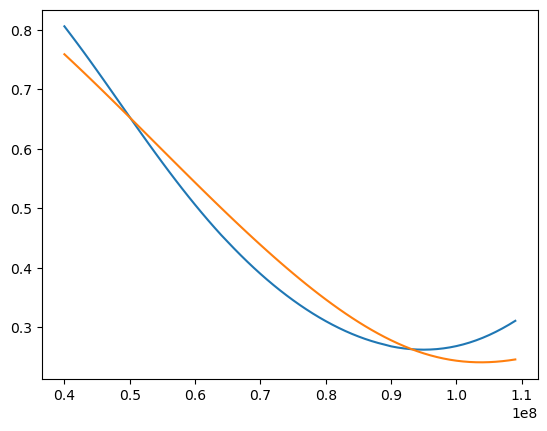

In [3]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_Model/saras3_S11_200mm_above_water.s1p", skiprows=5))

d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
c=3*10**8  # speed of light (m/s)
v=[d[i][0] for i in range(len(d)-1)] #frequency
df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_Model/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()

gamma_Asky=[d[i][1] for i in range(len(v))]
plt.plot(v, gamma_Asky)
plt.plot(v, rlc)

In [4]:
cc=np.polyfit(v, gamma_Asky, 7)
print(cc)
p0, p1, p2, p3, p4, p5, p6, p7=cc
kk=[-2.1647133934050, 1.0147954161718808, -1.901747474016836, 1.7749120622094145, -7.94569881994538, 1.0125132848620795, 1.9275338662378406, 5.234963195655749]
print([round(c,2) for c in kk])
fit = np.polyval(cc,v)

[-2.16471339e-55  1.01479542e-46 -1.90174747e-38  1.77491206e-30
 -7.94569882e-23  1.01251329e-15  1.92753387e-08  5.23496320e-01]
[-2.16, 1.01, -1.9, 1.77, -7.95, 1.01, 1.93, 5.23]


In [5]:
#PA for Sky
Po=200          #Kelvin
vo=150*1e6      #Hz
a=2.5           #spectral index
P_sky= [Po*(k/vo)**-a for k in v] 

In [6]:
def Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    l=l
    freq= [d[i][0] for i in range(len(d)-1)]
    for i in range(len(freq)):
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

In [297]:
def Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=11
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8

    N=8 #degree of polynomial
    freq= [d[i][0] for i in range(len(d)-1)]
    Po=200          #Kelvin
    vo=150*1e6      #Hz
    a=a           #spectral index
    P_sky= [Po*(k/vo)**-a for k in freq] 
    PA= P_sky
    for i in range(len(freq)):
        gamma_A=p0*1e-55* freq[i] ** (N - 1) + p1*1e-46* freq[i] ** (N - 2) + p2*1e-38* freq[i] ** (N - 3) + p3*1e-30* freq[i] ** (N - 4) + p4*1e-23* freq[i] ** (N - 5) + p5*1e-15* freq[i] ** (N - 6) + p6*1e-08*freq[i] ** (N - 7) + p7*1e-01
    
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA[i]*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

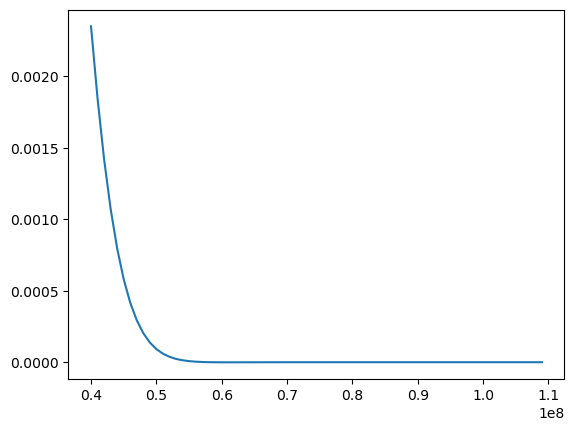

In [296]:
#sandbox
#test=Compute_Tmeas_Sky(2.5, 0,0,0,0,0,0,0,0, 70,0.3,0.1,0.15)
test1= Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,  1.77491206,
 -7.94569882,  1.01251329,  1.92753387,  5.23496320, 70,0.3,0.1,0.15,11)
test2= Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,  1.77491206,
 -7.94569882,  1.01251329,  1.92753387,  5.23496320, 70,0.3,0.1,0.15,12)
res_test=np.array(test1)-np.array(test2)

p0, p1, p2, p3, p4, p5, p6, p7 = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
s11test=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
p0, p1, p2, p3, p4, p5, p6, p7 = [-2.16471339,  1.01479542, -1.90174747,  1.77491206,
 -7.94569882,  1.01251329,  1.92753387,  5.23496320]
s11test1=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
plt.plot(v,res_test)
#plt.plot(v,test1,'or')

In [8]:
def Compute_Tmeas_Sky_exp(PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    
    N=8
    global rlc
    freq= [d[i][0] for i in range(len(d)-1)]
    gamma_A=gamma_Asky
    PA= P_sky
    for i in range(len(freq)):
        #print(gamma_A[i])
        #gamma_A=p0*1e-48* freq[i] ** (N - 1) + p1*1e-39* freq[i] ** (N - 2) + p2*1e-31* freq[i] ** (N - 3) + p3*1e-23* freq[i] ** (N - 4) + p4*1e-15* freq[i] ** (N - 5) + p5*1e-08* freq[i] ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A[i])**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A[i])**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A[i])**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA[i]*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A[i])**2)*C))
    return(Tmeas)

## MCMC for Sky

In [21]:
########## Define the log-likelihood function
def log_likelihood(params,**kwargs):

    #ip_params = kwargs["ip_params"]
    PN = kwargs["PN"]
    gamma_N = kwargs["gamma_N"]
    f = kwargs["f"]
    l = kwargs["l"]
    s = kwargs["s"]
    seed=kwargs["seed"]
    ip_params=kwargs["ip_params"]
    v=kwargs["v"]
    
    # Compute TA expected
    
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_Sky(*ip_params) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA
    a, p0, p1, p2, p3, p4, p5, p6, p7 = params
    TA_model = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):

    a, p0, p1, p2, p3, p4, p5, p6, p7 = params
    v=kwargs["v"]
    
    gamma_A=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
    if np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1:
        return 0.0  # Uniform prior
    return -np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_Sky(**kwargs):
    # Parameters: a, p0-p7
    
    ## Number of walkers and steps
    
    ndim = 9  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value = kwargs["initial_value"] 

    ## Starting positions for the walkers
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    
    print(len(pos_valid))
    pos = np.array(pos_valid)
    
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood(p,**kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples, samples, best_fit_params

In [22]:
#Evaluate MCMC
s=0.001
seed=381
v=[d[i][0] for i in range(len(d)-1)]
nsteps=3000
PN, gamma_N, f, l=[ 70.7, 0.38, 0.099, 0.13]
ip_params=[2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882, \
            1.01251329,  1.92753387,  5.23496320, 70.7, 0.38, 0.099, 0.13]
initials=[2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882, \
            1.01251329,  1.92753387,  5.23496320]
kwargs={"nsteps":nsteps,"initial_value":initials, "PN":PN, "gamma_N":gamma_N, "f":f, "l":l, "s":s, "v":v, "seed":seed, "ip_params":ip_params}

full_samples_sky, samples_sky, best_fit_params_sky= evolve_MCMC_Sky(**kwargs)

200
Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [18:29<00:00,  2.70it/s]


[2.5000173525463034, -2.0893002958595233, 0.966331380247907, -1.7728500666470102, 1.5893563692635189, -6.370797752685493, 0.2161975599756194, 4.182178140820355, 2.407814440524934]


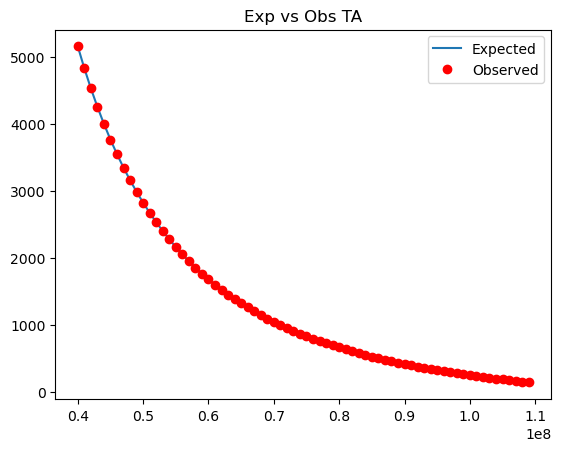

In [23]:
a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= [2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15]
TA1=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
a, p0, p1, p2, p3, p4, p5, p6, p7,= best_fit_params_sky
PN, gamma_N, f, l= [ 70, 0.3, 0.1, 0.15]
TA2=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
plt.plot(v,TA1,label="Expected")
plt.plot(v,TA2,'or',label="Observed")
plt.legend()
plt.title("Exp vs Obs TA")
print(best_fit_params_sky)

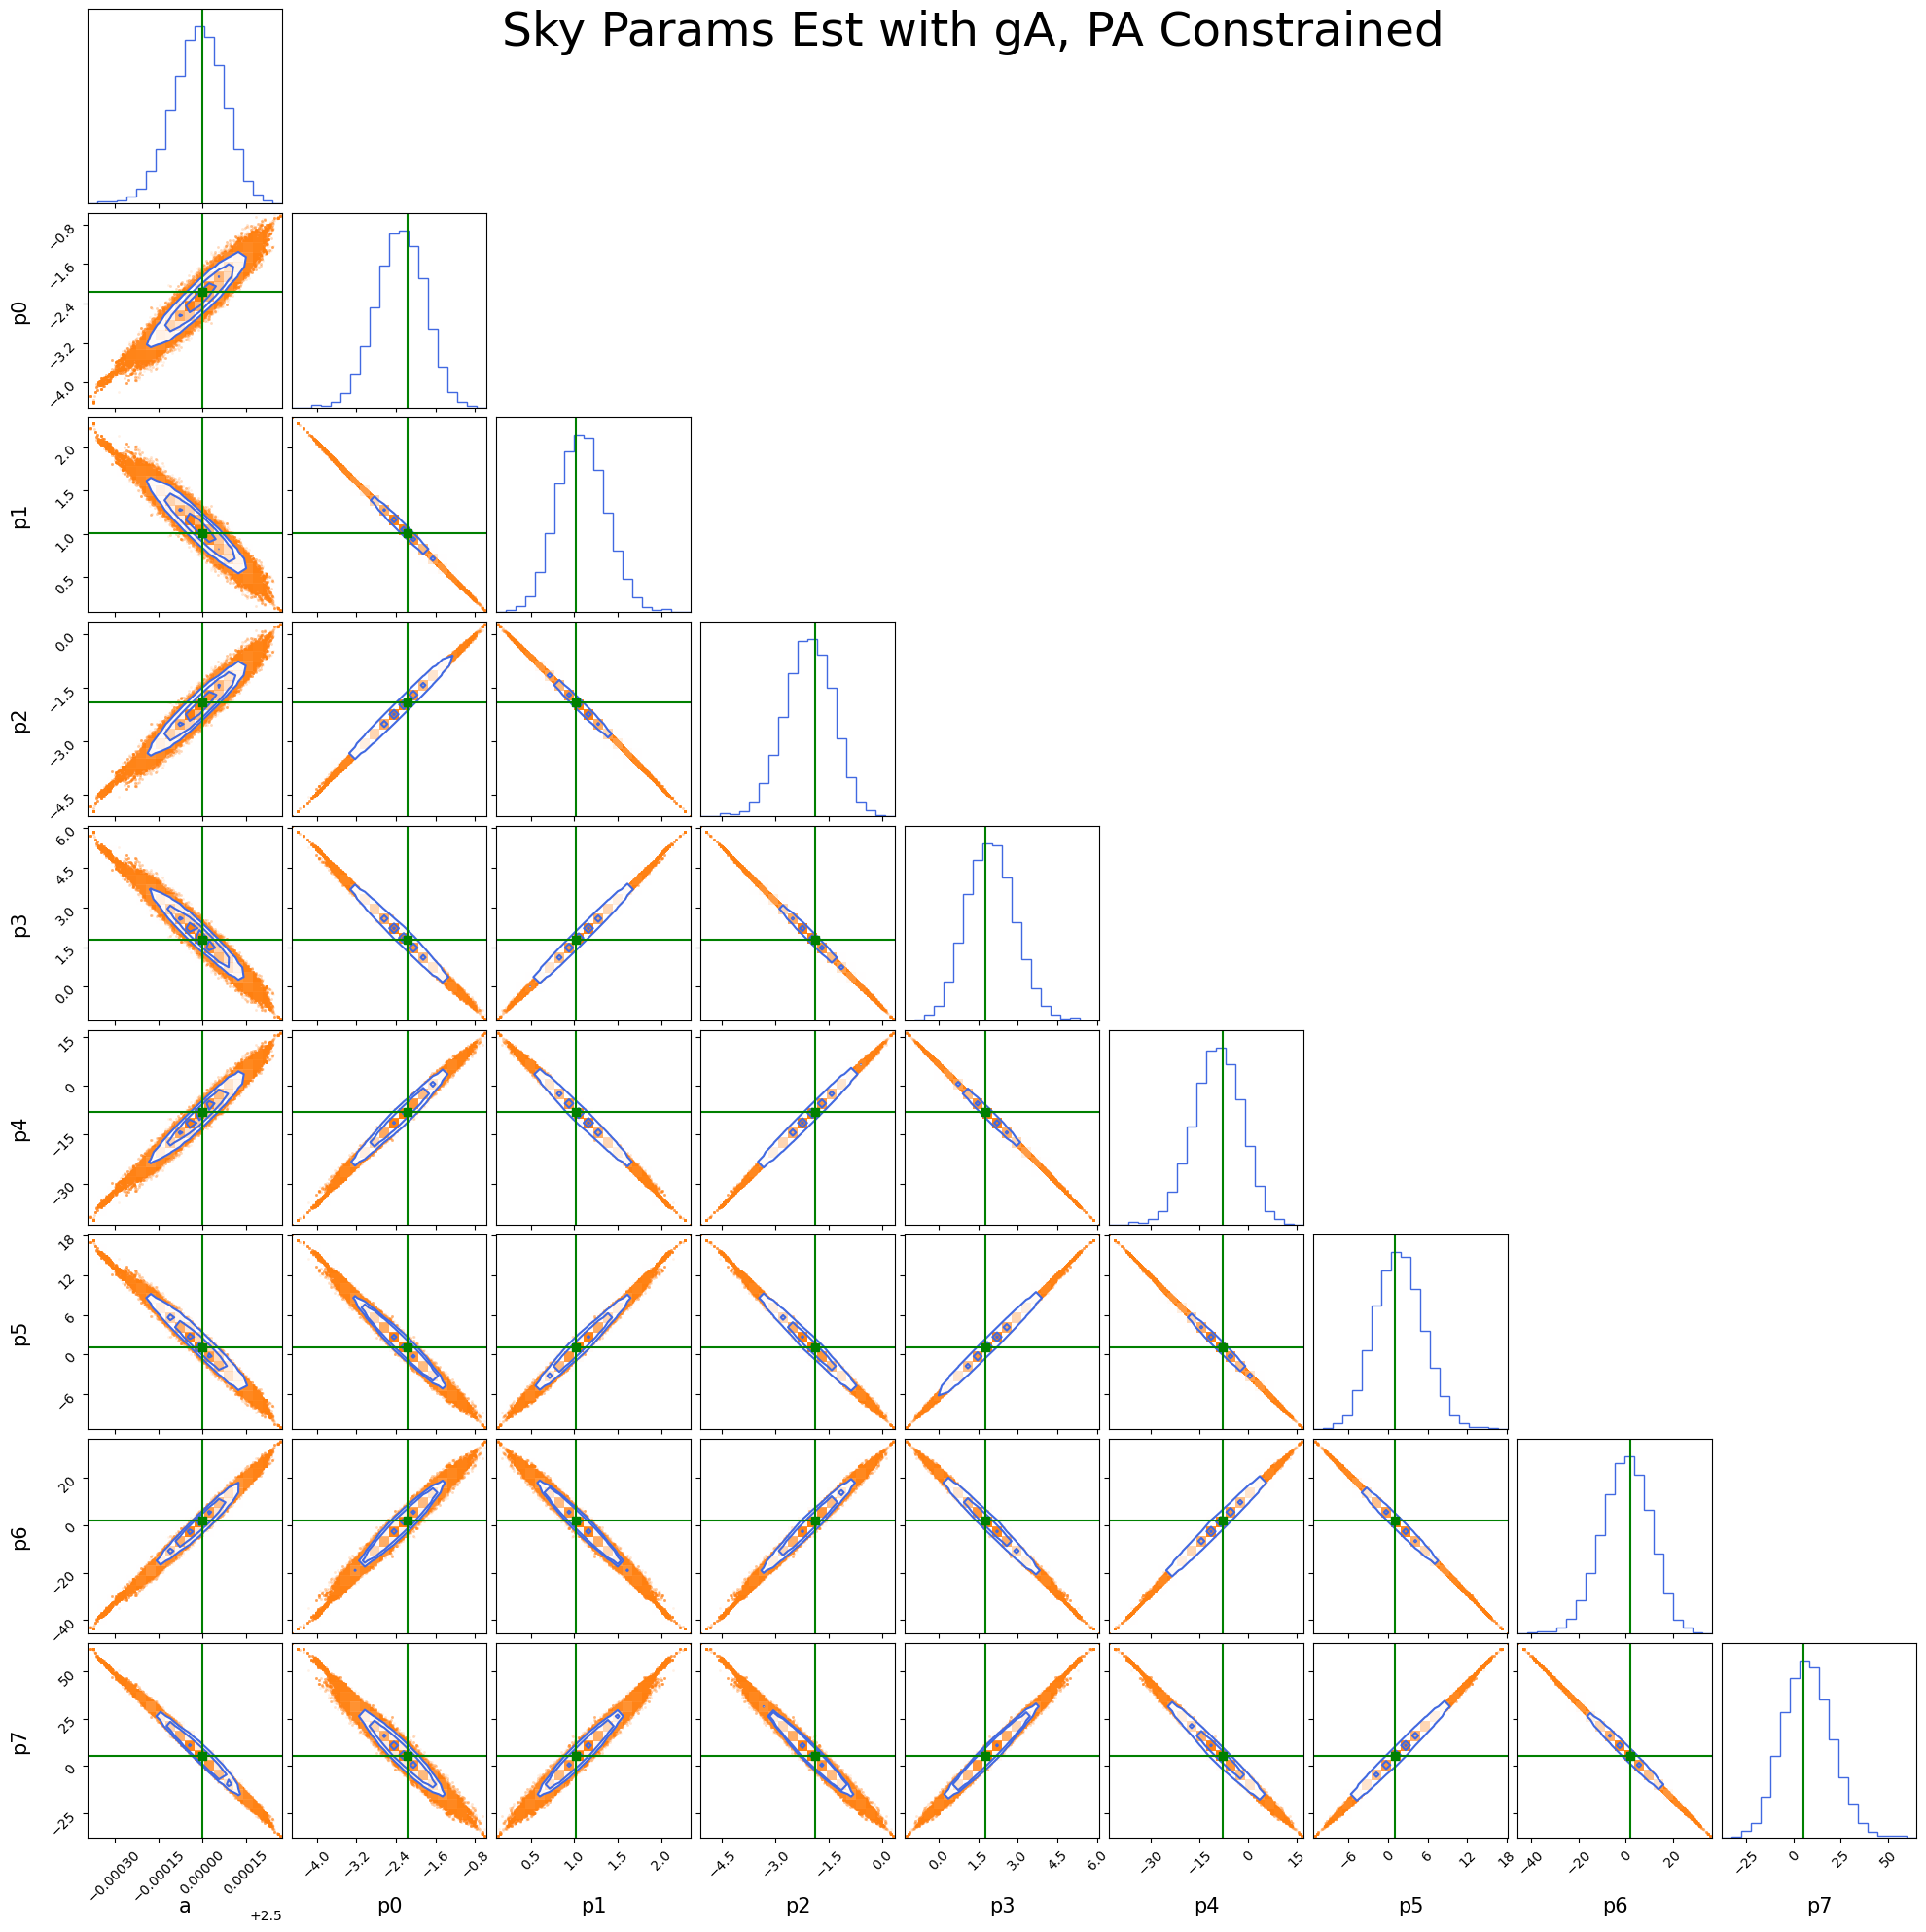

Expected Paramerters: [2.5, -2.16471339, 1.01479542, -1.90174747, 1.77491206, -7.94569882, 1.01251329, 1.92753387, 5.2349632, 70, 0.3, 0.1, 0.15]
Best-fit parameters (Maximum Likelihood Estimate): [2.5000173525463034, -2.0893002958595233, 0.966331380247907, -1.7728500666470102, 1.5893563692635189, -6.370797752685493, 0.2161975599756194, 4.182178140820355, 2.407814440524934]


In [137]:
#corner plot

parameter_names = ["a","p0", "p1", "p2", "p3", "p4", "p5", "p6","p7"]
ip_params_sky=[2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882, \
            1.01251329,  1.92753387,  5.23496320]
fig = corner.corner(samples_sky, labels=parameter_names, truths=ip_params_sky, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Sky Params Est with gA, PA Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_gA_PA_2m_1.png', dpi=300)
plt.show()

print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_sky)

In [25]:
nsamples, nparam = samples_sky.shape

In [26]:
reduced_samples_sky = samples_sky

In [27]:
#computing S11 corresponding to all samples
S11_models_sky = np.zeros((len(reduced_samples_sky), len(v)))

for ii in range(len(reduced_samples_sky)):
    a, p0, p1, p2, p3, p4, p5, p6, p7= reduced_samples_sky[ii]
    S11_models_sky[ii]=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
   

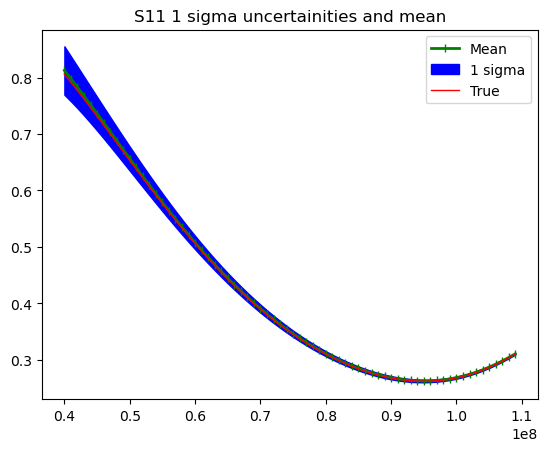

In [29]:
## plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
#plt.plot(v, S11_models_sky[0::100].T, alpha=0.1)

S11_mean = np.mean(S11_models_sky, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_sky,[16,84],axis=0)

plt.plot(v, S11_mean, lw=2, color='g', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")

gA_True=np.polyval([-2.16471339e-55,  1.01479542e-46, -1.90174747e-38,  1.77491206e-30, -7.94569882e-23, \
                    1.01251329e-15,  1.92753387e-08,  5.23496320e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.legend()
plt.title("S11 1 sigma uncertainities and mean")
plt.show()

Text(0.5, 1.0, 'Uncertainities in TA estimation')

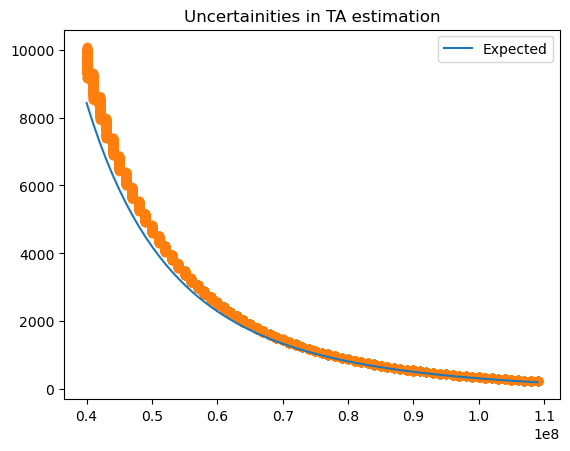

In [108]:
#Reconstructing TA 
plt.figure()
TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                        1.77491206, -7.94569882, 1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
for ii in range(len(reduced_samples_sky[::100])):
    a, p0, p1, p2, p3, p4, p5, p6, p7= reduced_samples_sky[ii]
    PN, gamma_N, f, l= [70.7, 0.38, 0.099, 0.13]
    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    err=(np.array(TA_obs)-np.array(TA_exp))/np.array(TA_exp)
    plt.plot(v, TA_obs, color='C1', marker='o',alpha=0.1, lw=1)


plt.plot(v,TA_exp,label="Expected")
plt.legend()
plt.title('Uncertainities in TA estimation')

Text(0, 0.5, 'S11')

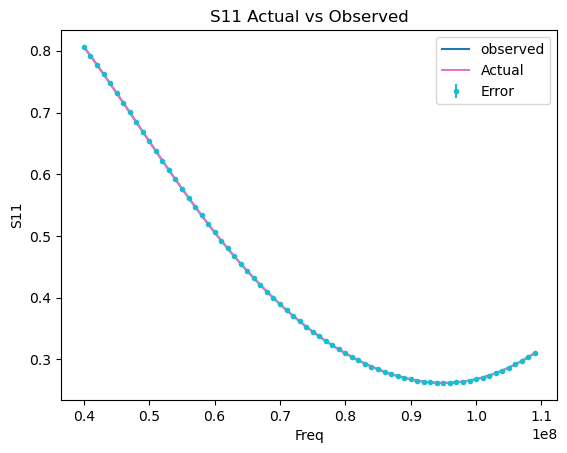

In [20]:
#Reconstructed S11 wrt best fit

a, p0, p1, p2, p3, p4, p5, p6, p7 =best_fit_params_sky
gamma_A=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
yerr=abs(gamma_Asky-gamma_A)
plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
plt.plot(v,gamma_Asky,'tab:pink', label='Actual')
plt.title("S11 Actual vs Observed")
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')

## Open

In [50]:
########## Define the log-likelihood function
def log_likelihood_o(params,**kwargs):
    ip_params=kwargs["ip_params"]
    seed=kwargs["seed"]
    s = kwargs["s"]  # Uncertainty
    
    PA, gamma_A, PN, gamma_N, f, l = params
    
    # Define the Expected TA values
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_(*ip_params) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA
    TA_model = Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f,  l)
    TA_model=np.array(TA_model)

    # Compute chi-squared with weights
    
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)  # Likelihood function

########## Define the log-prior function
def log_prior_o(params):
    
    PA, gamma_A, PN, gamma_N, f, l = params

    if ((0 <= gamma_A <= 1) and (0 <= gamma_N <= 1) and (0<=PA<=3) and (50<=PN<=150) and (0.05<=f<=0.5) and (0.05<l<2)) : 
            return 0.0  # Reject sample
    return -np.inf # Uniform prior

######### Define the full log-probability function

def log_probability_o(params,**kwargs):
    lp = log_prior_o(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_o(params,**kwargs)

########### MCMC

def evolve_MCMC_o(**kwargs):# Define parameter names
    parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]

    # Number of walkers and steps
    ndim = 6  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    ## Starting positions for the walkers
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    pos= initial_value[None,:] + initial_value*1e-2*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability_o(params):
        return log_probability_o(params,**kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability_o, threads=10)
    print(sampler.acceptance_fraction) #Mean Acceptance Ration
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples_o=sampler.get_chain()

    samples_o = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes_o = np.array([log_likelihood_o(p, **kwargs) for p in samples_o])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes_o)
    
    ########## Get the best-fit parameters
    best_fit_params_o = samples_o[max_likelihood_index].tolist()

    return full_samples_o,samples_o,best_fit_params_o

In [51]:
#evolve MCMC
ip_params=[0,1,70,0.3,0.1,0.15] #input parameters
nsteps=3000
initials=[0.007,0.97,70.7,0.29,0.1,0.13]
s=0.001
seed=158
kwargs={"s":s,"seed":seed, "nsteps":nsteps, "ip_params":ip_params, "initial_value":initials}
full_samples_o, samples_o, best_fit_params_o= evolve_MCMC_o(**kwargs)

/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/emcee/ensemble.py:542: RuntimeWarning: invalid value encountered in divide
  return self.backend.accepted / float(self.backend.iteration)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [27:25<00:00,  1.82it/s]


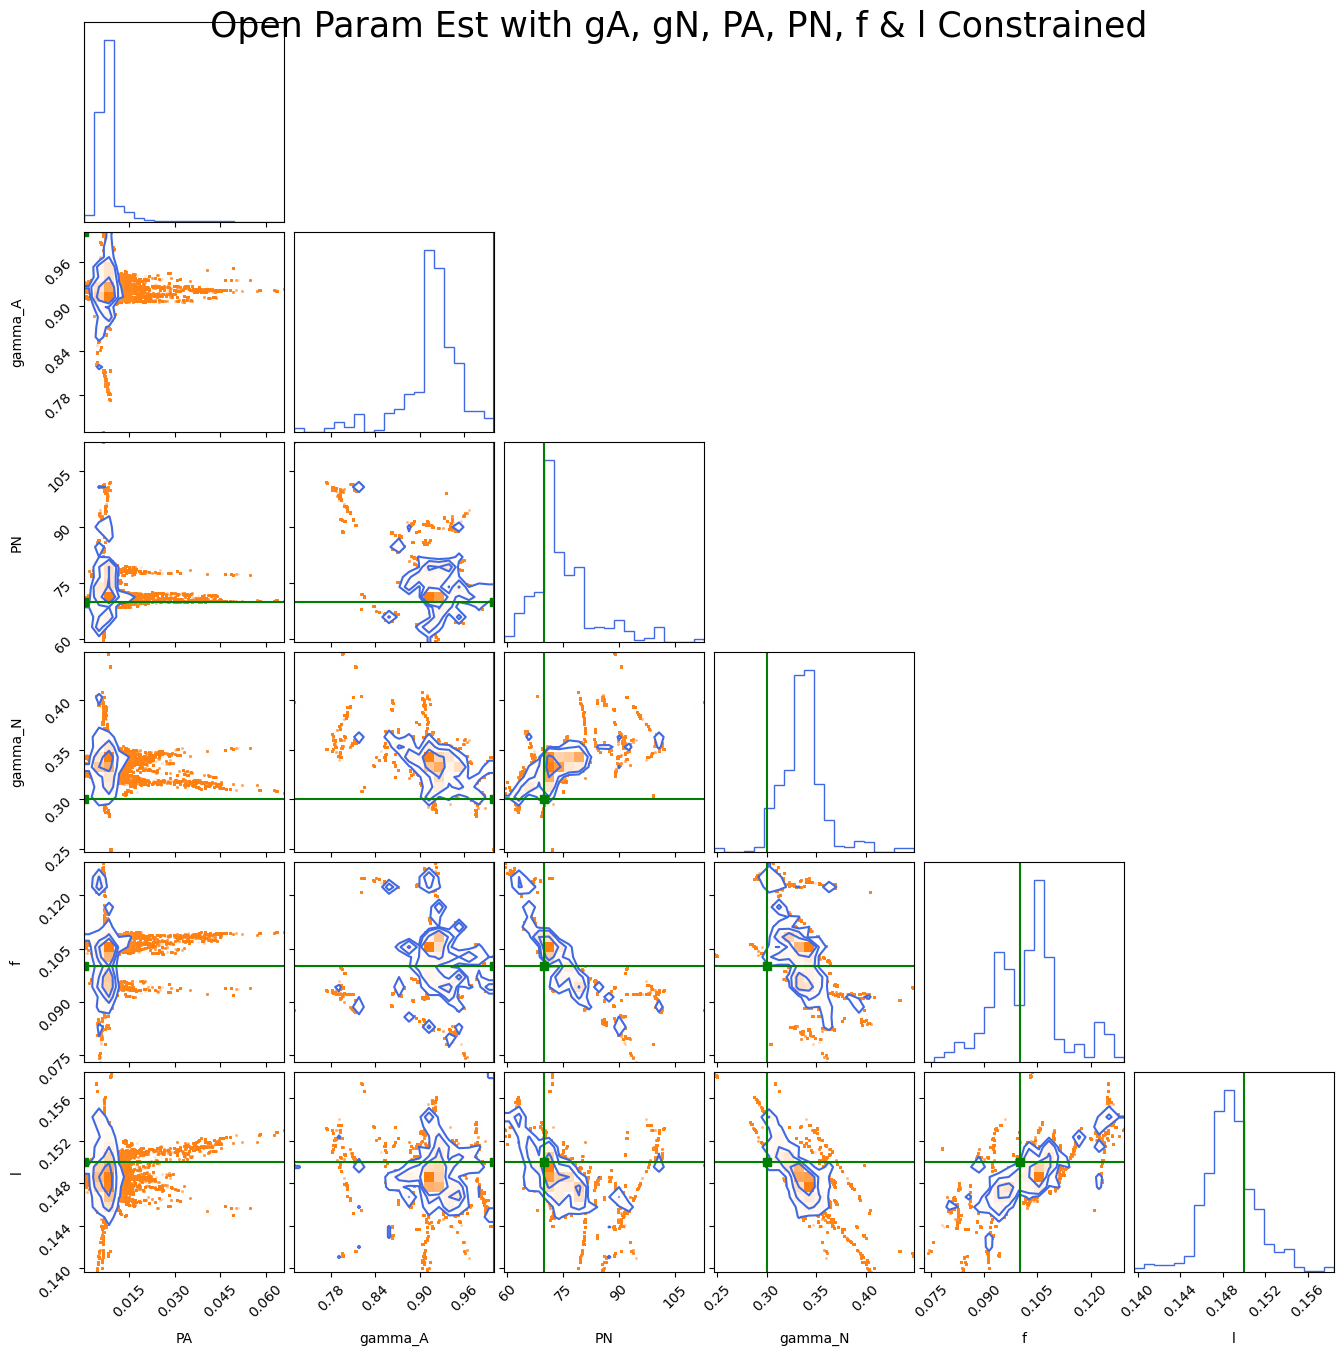

Best-fit parameters (Maximum Likelihood Estimate): [0.008534425123264218, 0.9250742094605962, 69.50949445142118, 0.32459320793022317, 0.1087124583968724, 0.15003611227753147]


In [52]:
parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_o, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Open Param Est with gA, gN, PA, PN, f & l Constrained", fontsize=25)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/Open_All_15cm_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_o)

## Sky Params (Open as Fixed)

In [139]:
########## Define the log-likelihood function
def log_likelihood(params,**kwargs):

    ip_params = kwargs["ip_params"]
    PN = kwargs["PN"]
    gamma_N = kwargs["gamma_N"]
    f = kwargs["f"]
    l = kwargs["l"]
    s = kwargs["s"]
    seed=kwargs["seed"]

    # Compute TA expected
    
    a, p0, p1, p2, p3, p4, p5, p6, p7 = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    a, p0, p1, p2, p3, p4, p5, p6, p7 = params
    TA_model = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):

    a, p0, p1, p2, p3, p4, p5, p6, p7 = params
    v=kwargs["v"]
    
    gamma_A=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and a>0):
        return 0.0  # Uniform prior
    return -np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_Sky_fix(**kwargs):
        
    ## Number of walkers and steps
    
    ndim = 9  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value = kwargs["initial_value"] 

    ## Starting positions for the walkers
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood(p,**kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [140]:
#Evolve MCMC
s=0.001
seed=61
v=[d[i][0] for i in range(len(d)-1)]
nsteps=3000
PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
ip_params=[2.5, -2.16471339,  1.01479542, -1.90174747,\
                        1.77491206, -7.94569882, 1.01251329,  1.92753387,  5.23496320]
initials=[2.3, -2.16471339,  1.01479542, -1.90174747,\
                        1.77491206, -7.94569882, 1.01251329,  1.92753387,  5.23496320]

kwargs={"nsteps":nsteps,"initial_value":initials,"ip_params": ip_params, "PN":PN,  "gamma_N":gamma_N, "f":f, "l":l, "s":s, "v":v, "seed":seed}

full_samples_sky_fix, samples_sky_fix, best_fit_params_sky_fix= evolve_MCMC_Sky_fix(**kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [37:13<00:00,  1.34it/s]


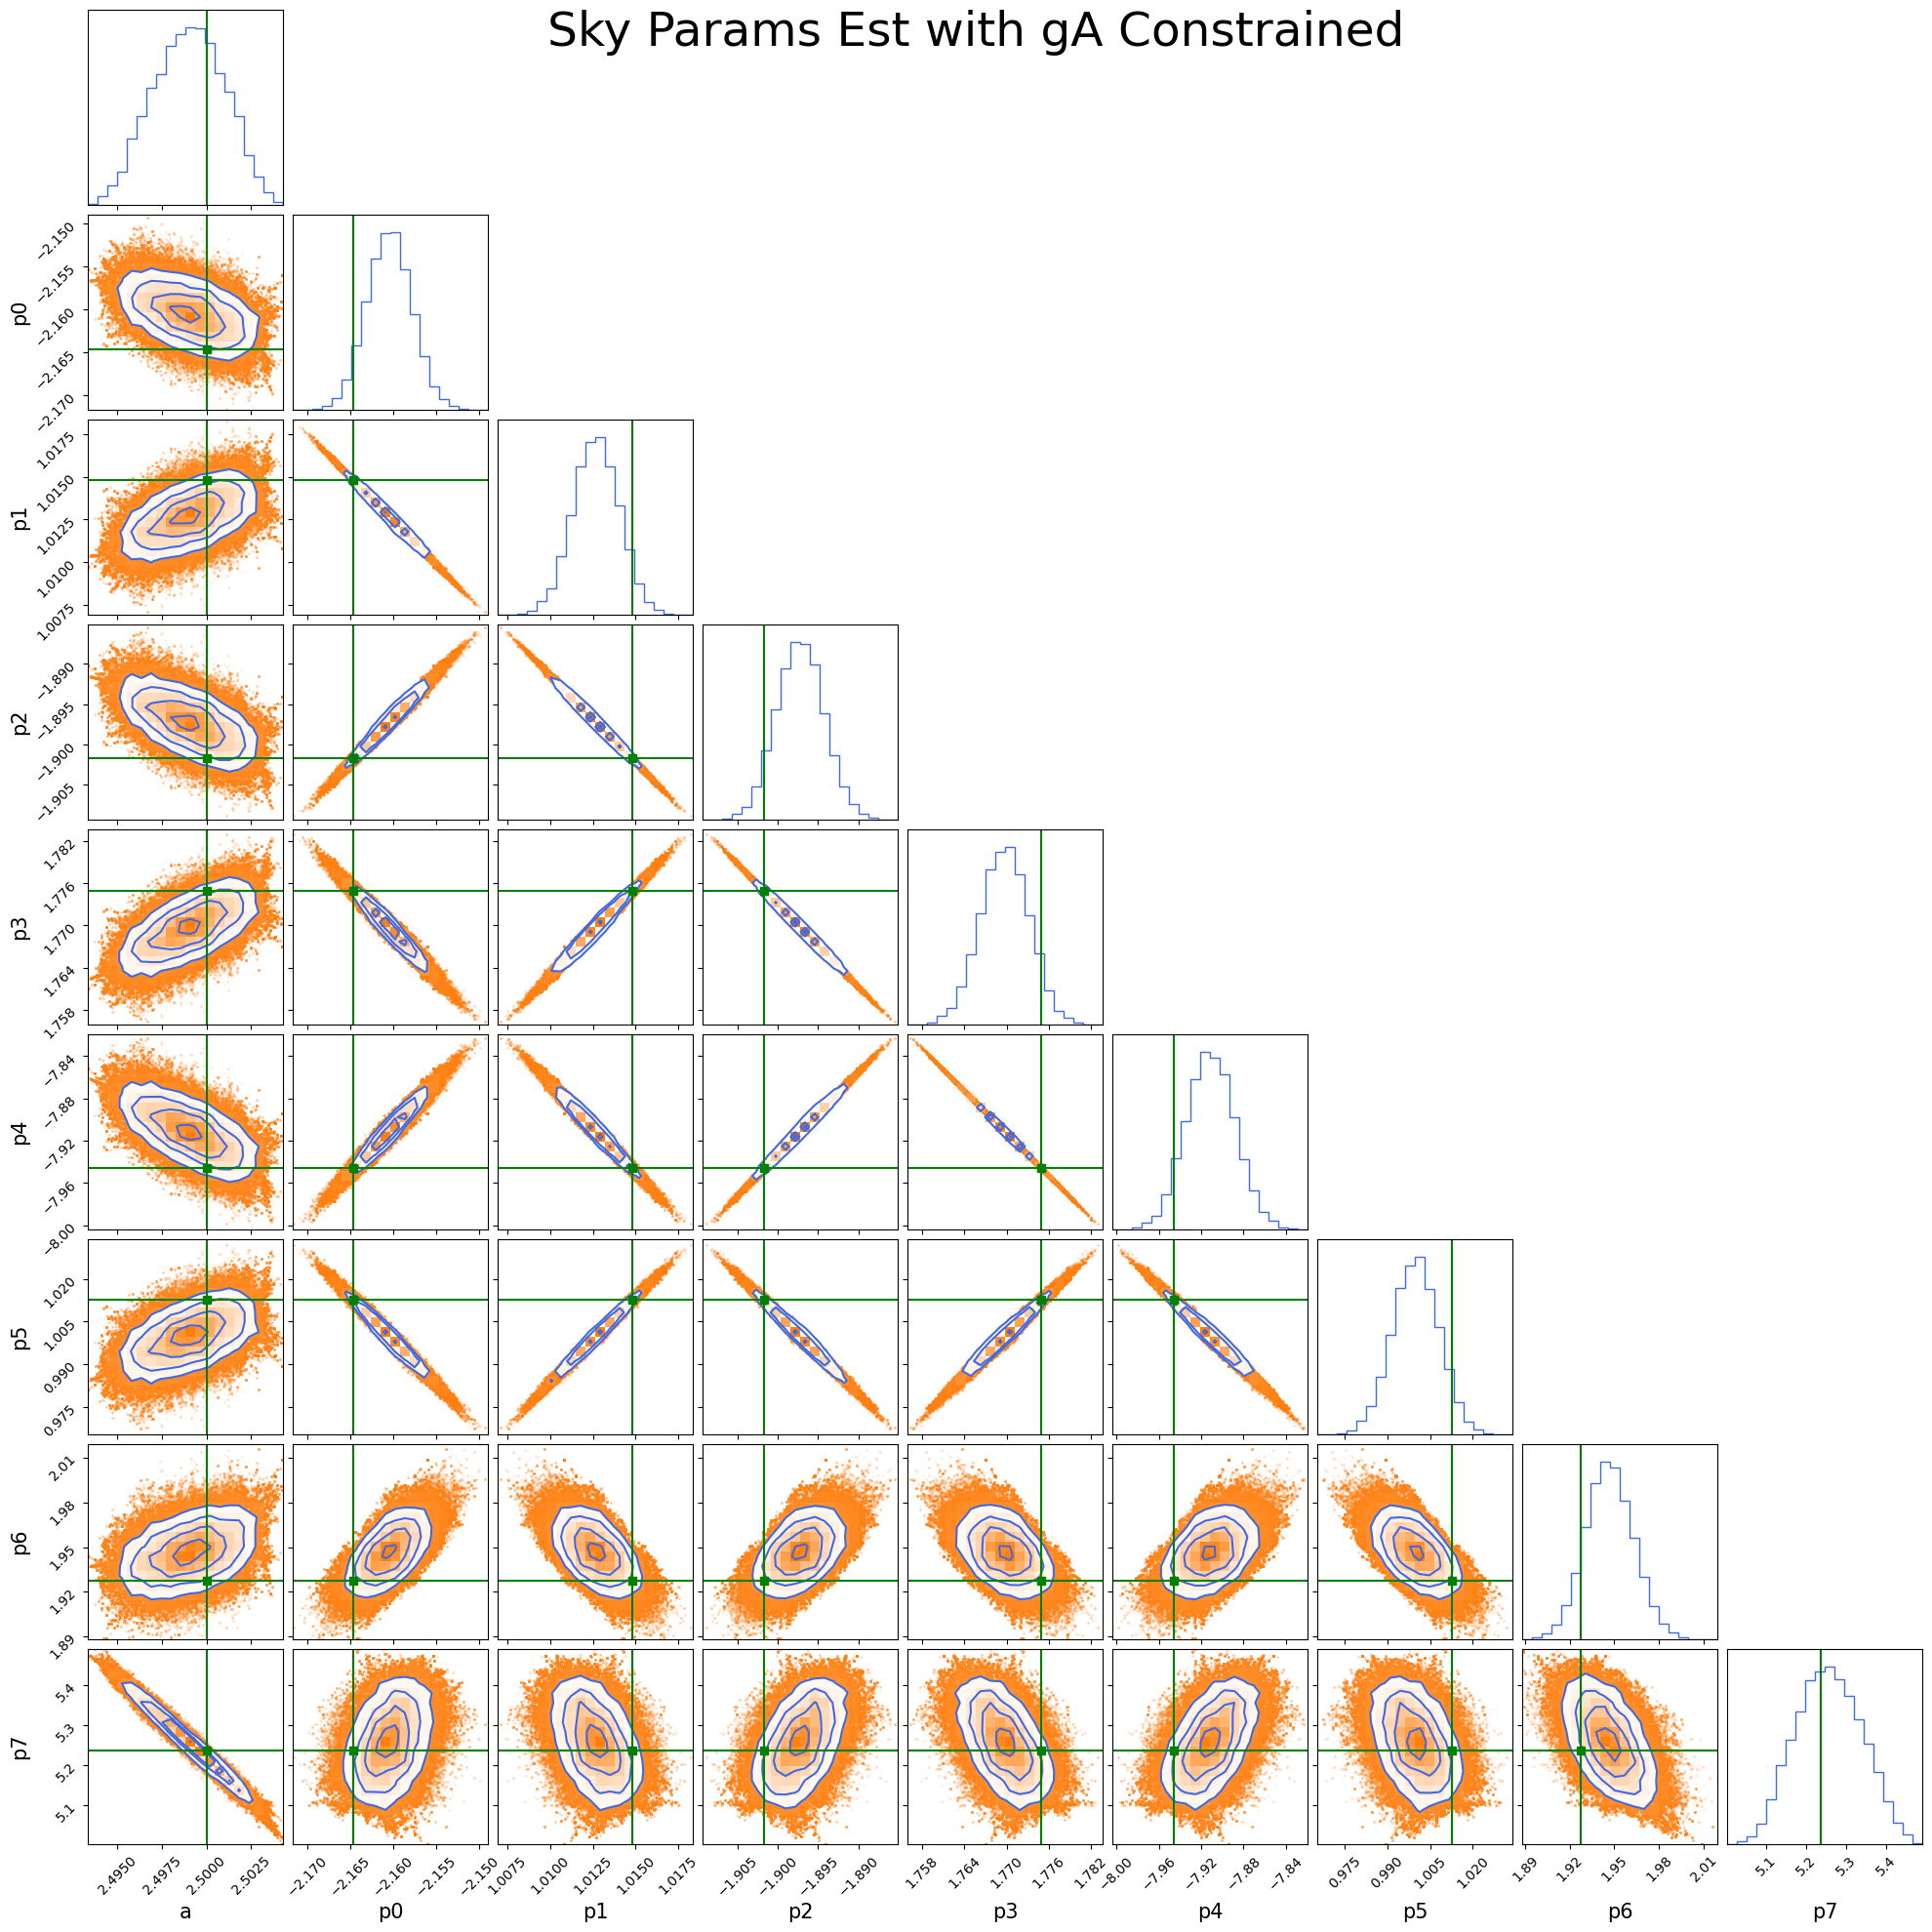

Best-fit parameters (Maximum Likelihood Estimate): [2.499412253200053, -2.1607591628356833, 1.0128325576753985, -1.8976416548948847, 1.7702441890653688, -7.91488920534386, 1.0010369833088095, 1.9472489777206594, 5.239824280382101]


In [143]:
parameter_names = ["a", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7"]
#corner plot 
fig = corner.corner(samples_sky_fix, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Sky Params Est with gA Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_gA_PA_2m_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_sky_fix)

Text(0.5, 1.0, 'S11 exp vs obs')

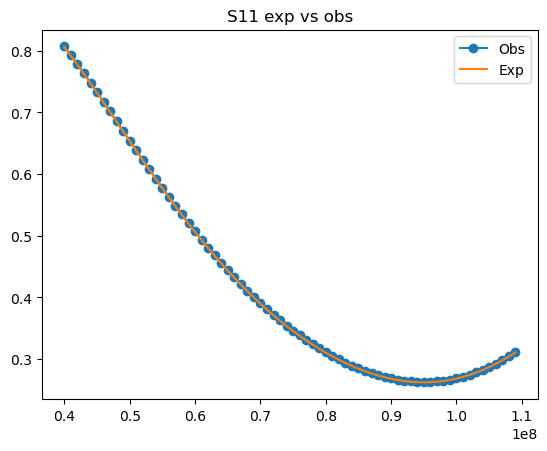

In [141]:
#Expected vs Observed
a, p0, p1, p2, p3, p4, p5, p6, p7= best_fit_params_sky_fix
PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
S11_obs=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320
S11_actual=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
plt.plot(v, S11_obs, marker='o', label="Obs")
plt.plot(v, S11_actual, label="Exp")
plt.legend()
plt.title("S11 exp vs obs")

Text(0.5, 1.0, 'Tmeas exp vs obs')

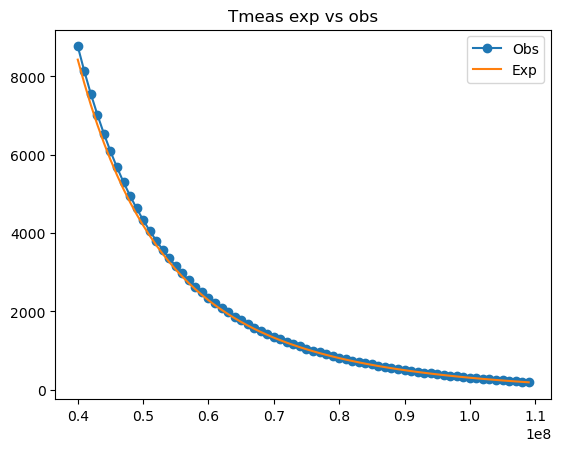

In [142]:
plt.plot(v, TA_obs, marker='o', label="Obs")
plt.plot(v, TA_exp, label="Exp")
plt.legend()
plt.title("Tmeas exp vs obs")

In [144]:
#computing S11 corresponding to all samples
reduced_samples_sky_fix = samples_sky_fix
S11_models_sky_fix = np.zeros((len(reduced_samples_sky_fix), len(v)))

for ii in range(len(reduced_samples_sky_fix)):
    a, p0, p1, p2, p3, p4, p5, p6, p7= reduced_samples_sky_fix[ii]
    S11_models_sky_fix[ii]=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)

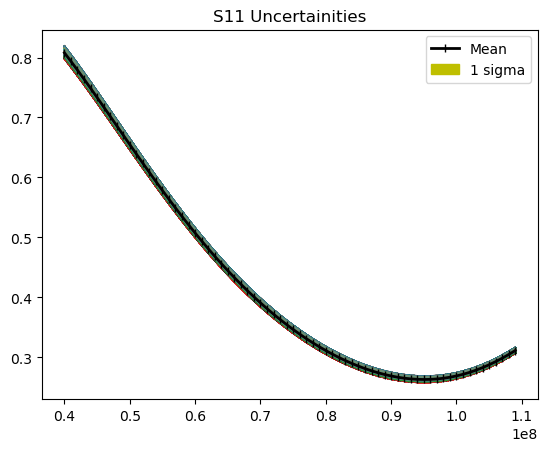

In [145]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
plt.plot(v, S11_models_sky_fix[0::10].T, alpha=0.1)

S11_mean_sky_fix = np.mean(S11_models_sky_fix, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_sky_fix,[16,84],axis=0)

plt.plot(v, S11_mean_sky_fix, lw=2, color='k', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='y', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320

gA_True=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
#plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.legend()
plt.title("S11 Uncertainities")
plt.show()

Text(0.5, 1.0, 'Uncertainity in TA estimation')

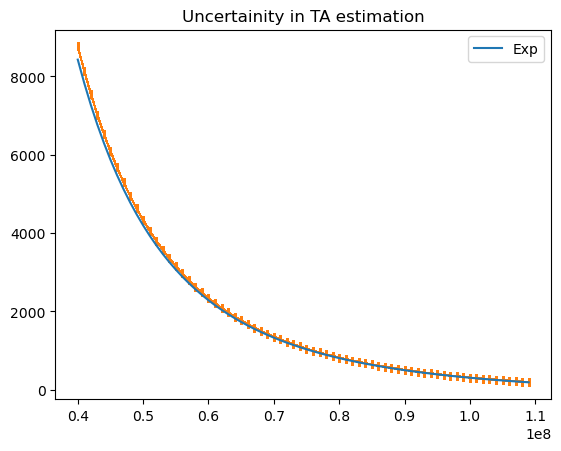

In [146]:
#Reconstructing TA 
plt.figure()
for ii in range(len(reduced_samples_sky_fix[::100])):
    a, p0, p1, p2, p3, p4, p5, p6, p7= reduced_samples_sky_fix[ii]
    PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    
    plt.plot(v, TA_obs, color='C1', marker='|',alpha=0.1, lw=1)

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
plt.plot(v,TA_exp, label="Exp")
plt.legend()
plt.title('Uncertainity in TA estimation')

Text(0.5, 1.0, 'Residuals in TA estimation')

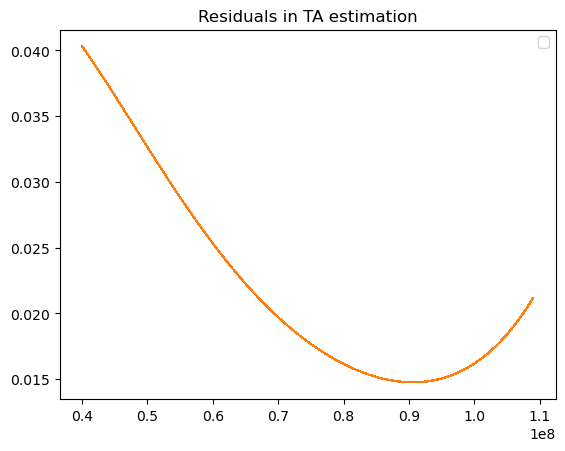

In [150]:
#Residuals in measuring TA 
plt.figure()

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
for ii in range(len(reduced_samples_sky_fix[::100])):
    a, p0, p1, p2, p3, p4, p5, p6, p7= reduced_samples_sky_fix[ii]
    PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    res=(np.array(TA_obs)-np.array(TA_exp))/np.array(TA_exp)
    plt.plot(v, res, color='C1',alpha=0.1, lw=1)

plt.legend()
plt.title('Residuals in TA estimation')

## Sky Full Params (With Open as initials)

In [298]:
########## Define the log-likelihood function
def log_likelihood(params,**kwargs):

    ip_params = kwargs["ip_params"]
    s = kwargs["s"]
    seed=kwargs["seed"]
    v=kwargs["v"]

    # Compute TA expected
    
    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN,gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):
    
    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l = params

    v=kwargs["v"]
    
    gamma_A=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and (0<=gamma_N<=1) and a>0 and PN>0 and f>0 and l>0):#(250<PA<350) and (50<PN<150) and (0.05<f<0.5) and l>0):
        return 0.0  # Uniform prior
    return -np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_Sky_ini(**kwargs):
    
    ## Number of walkers and steps
    
    ndim = 13  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=kwargs["initial_value"]

    ## Starting positions for the walkers
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler_sky_ini = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    mean_acc_frac=np.mean(sampler_sky_ini.acceptance_fraction)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler_sky_ini.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples_sky_ini=sampler_sky_ini.get_chain()
    samples_sky_ini = sampler_sky_ini.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes_sky_ini = np.array([log_likelihood(p,**kwargs) for p in samples_sky_ini])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes_sky_ini)
    
    ## Get the best-fit parameters
    
    best_fit_params_sky_ini = samples_sky_ini[max_likelihood_index].tolist()

    return full_samples_sky_ini,samples_sky_ini,best_fit_params_sky_ini, mean_acc_frac #Mean Acceptance Ratio

In [299]:
s=0.001
seed=178
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
ip_params=[2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15]
PAo,gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
a, p0, p1, p2, p3, p4, p5, p6, p7=[2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320]
initials=[a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l]


kwargs={"nsteps": nsteps, "ip_params": ip_params, "initial_value": initials, "s":s, "v":v, "seed":seed} #"PN":PN,  "gamma_N":gamma_N, "f":f, "l":l,


full_samples_sky_ini, samples_sky_ini, best_fit_params_sky_ini, mean_acc_frac= evolve_MCMC_Sky_ini(**kwargs)

/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/emcee/ensemble.py:542: RuntimeWarning: invalid value encountered in divide
  return self.backend.accepted / float(self.backend.iteration)


Running MCMC...


100%|█████████████████████████████████████| 3000/3000 [1:25:21<00:00,  1.71s/it]


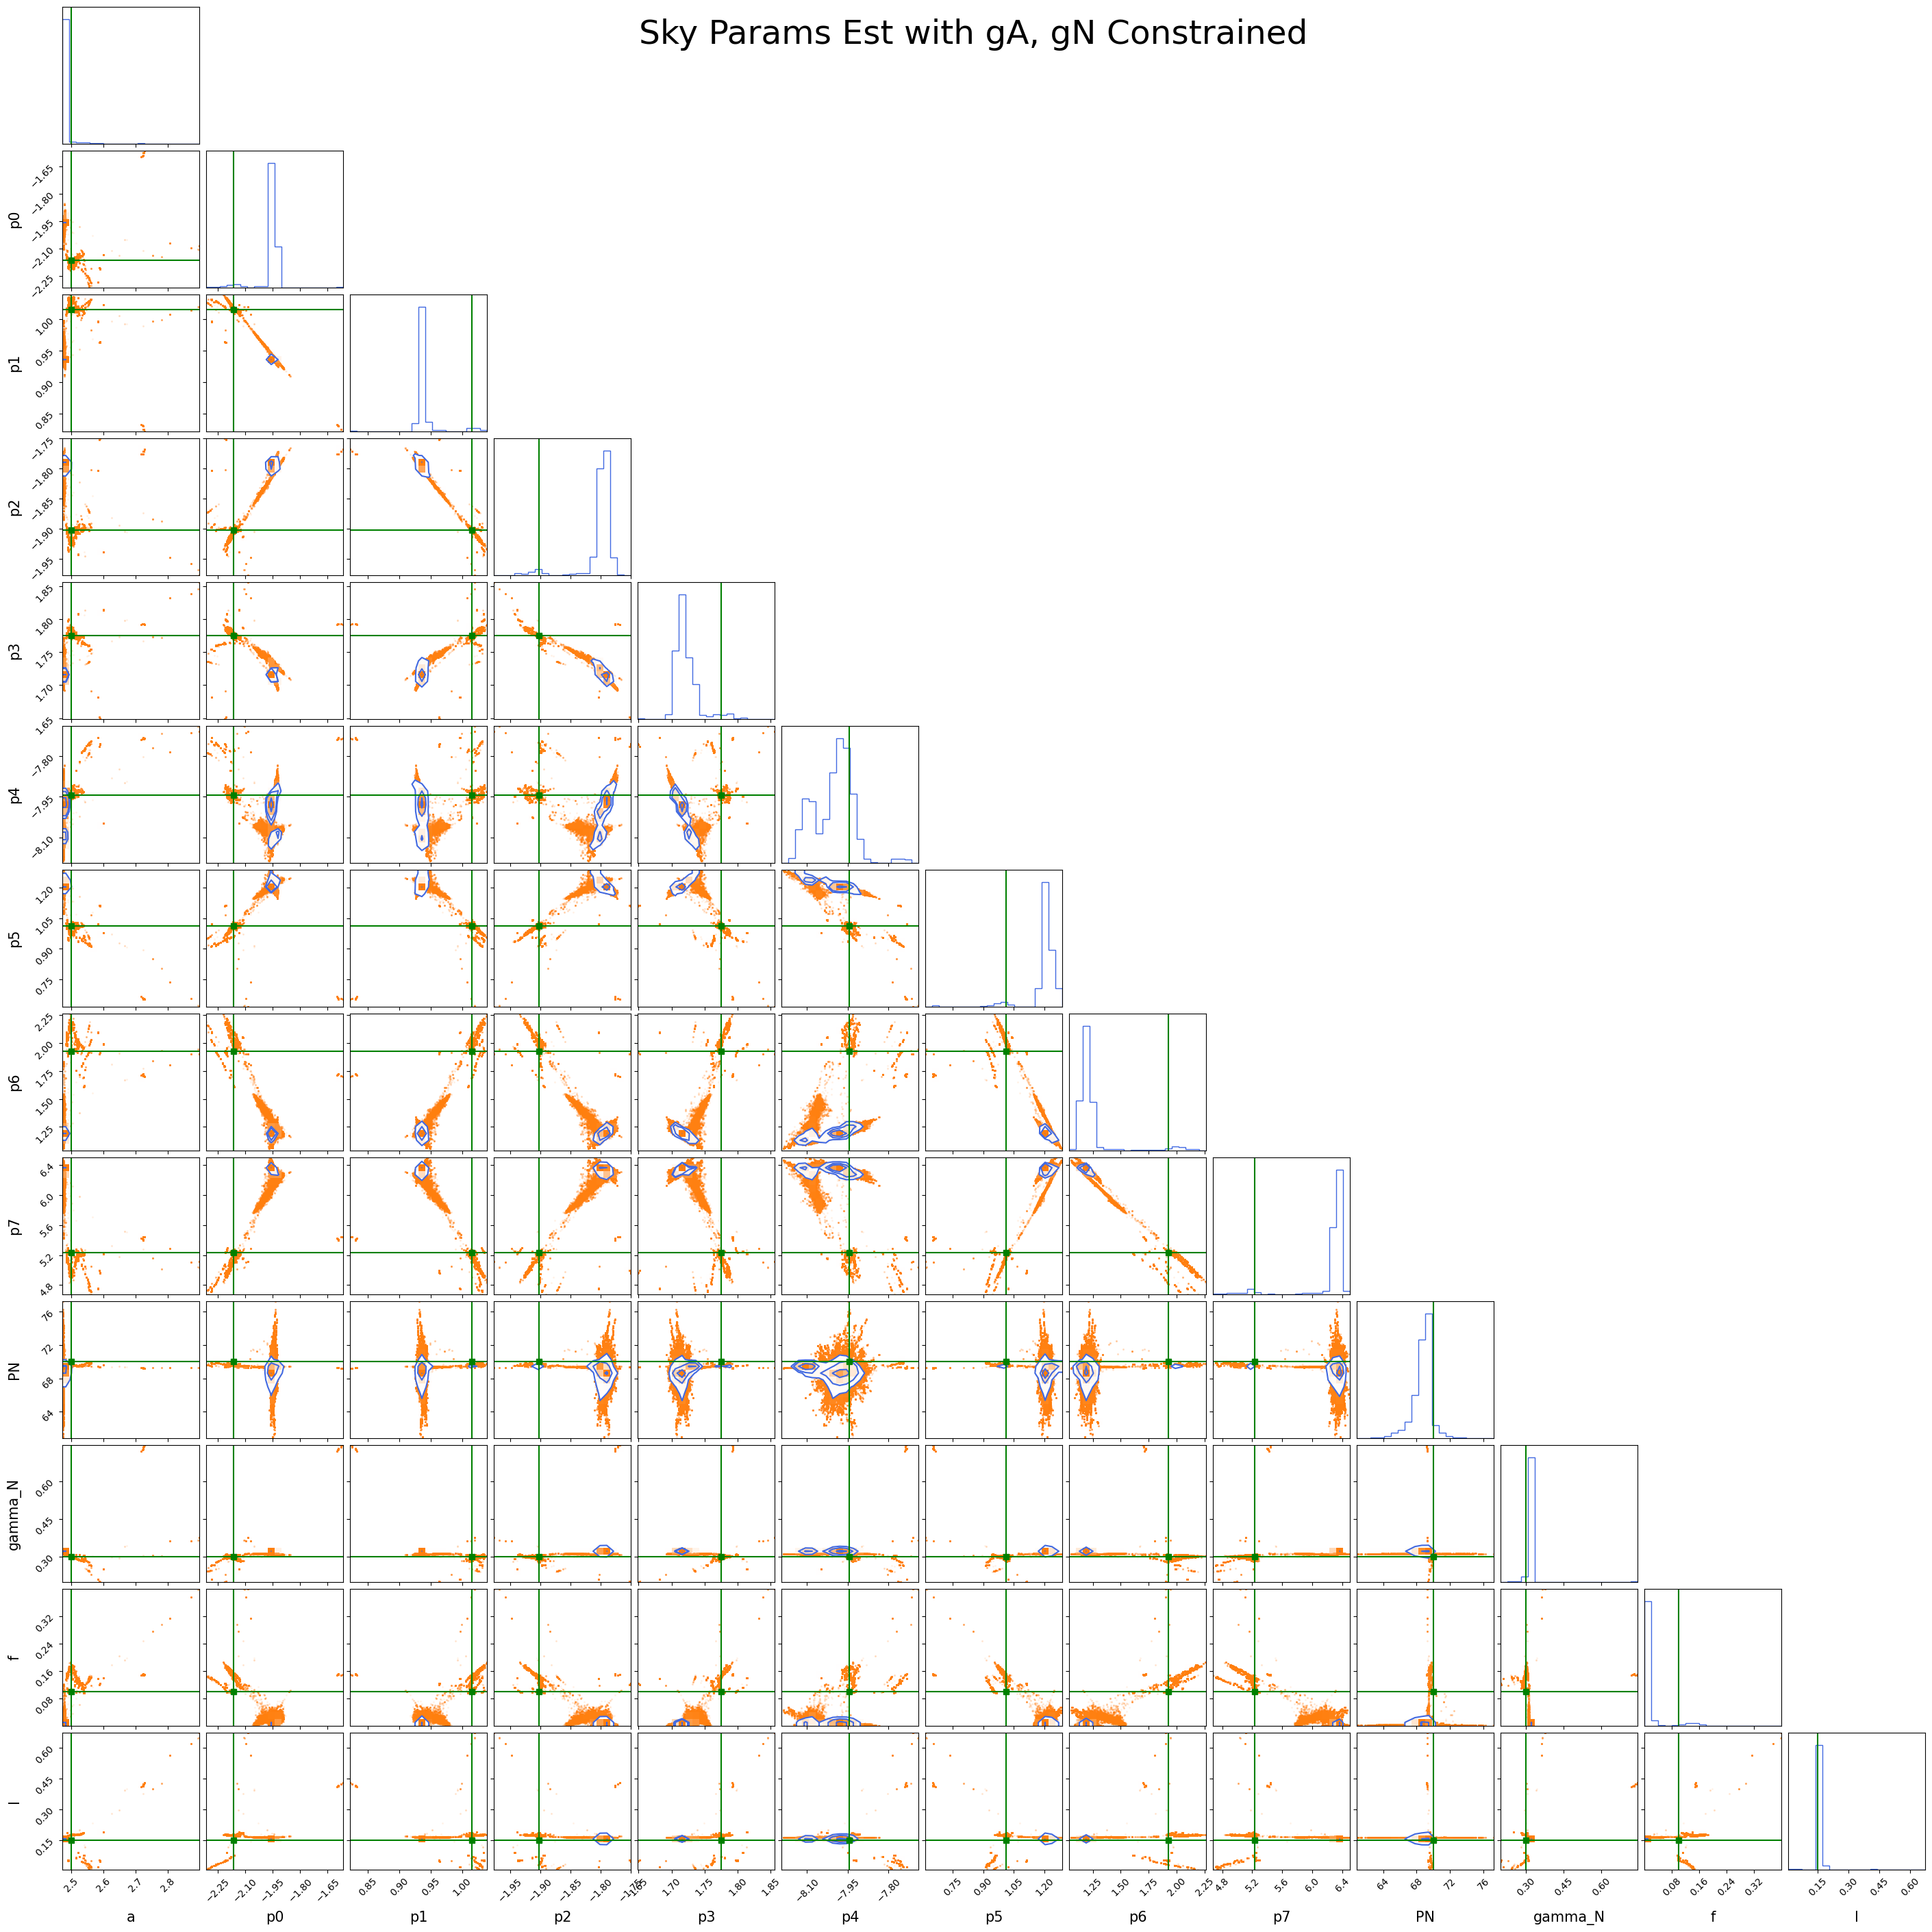

True values: [2.5, -2.16471339, 1.01479542, -1.90174747, 1.77491206, -7.94569882, 1.01251329, 1.92753387, 5.2349632, 70, 0.3, 0.1, 0.15]
Best-fit parameters (Maximum Likelihood Estimate): [2.4748614877084285, -1.9569531021455862, 0.9401193307674707, -1.7996710686683228, 1.720212941449299, -8.015468668488586, 1.2178598877607176, 1.17312228276514, 6.380382649305837, 68.92362297119043, 0.31039476149315637, 0.001056645389065818, 0.16155611331525946]


In [300]:
parameter_names = ["a", "p0", "p1", "p2", "p3", "p4", "p5", "p6","p7","PN","gamma_N","f","l"]
#corner plot 
fig = corner.corner(samples_sky_ini, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Sky Params Est with gA, gN Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/RLC_1m_gA_gN_PA_l_1.png', dpi=300)
plt.show()

print("True values:", ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_sky_ini)

Text(0.5, 1.0, 'S11 exp vs obs')

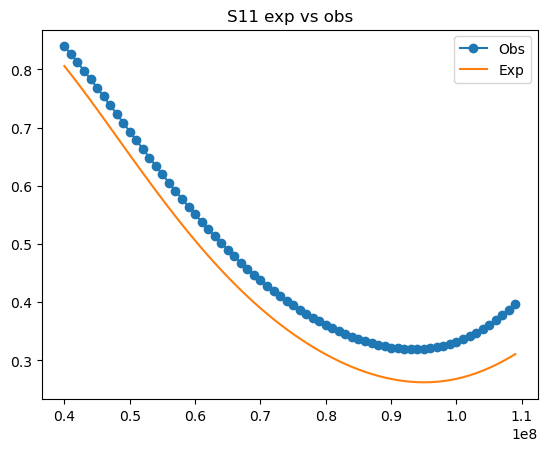

In [301]:
a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= best_fit_params_sky_ini
TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
S11_obs=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320
S11_actual=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
plt.plot(v, S11_obs, marker='o', label="Obs")
plt.plot(v, S11_actual, label="Exp")
plt.legend()
plt.title("S11 exp vs obs")

Text(0.5, 1.0, 'Tmeas exp vs obs')

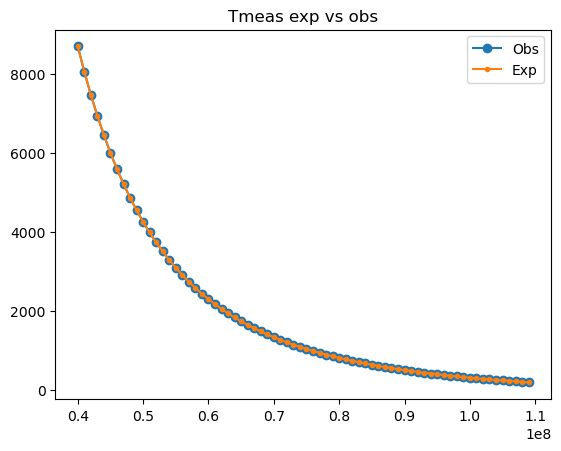

In [302]:
plt.plot(v, TA_obs, marker='o', label="Obs")
plt.plot(v, TA_exp, marker='.', label="Exp")
plt.legend()
plt.title("Tmeas exp vs obs")

In [303]:
#computing S11 corresponding to all samples
reduced_samples_sky_ini = samples_sky_ini
S11_models_sky_ini = np.zeros((len(reduced_samples_sky_ini), len(v)))

for ii in range(len(reduced_samples_sky_ini)):
    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_sky_ini[ii]
    S11_models_sky_ini[ii]=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)

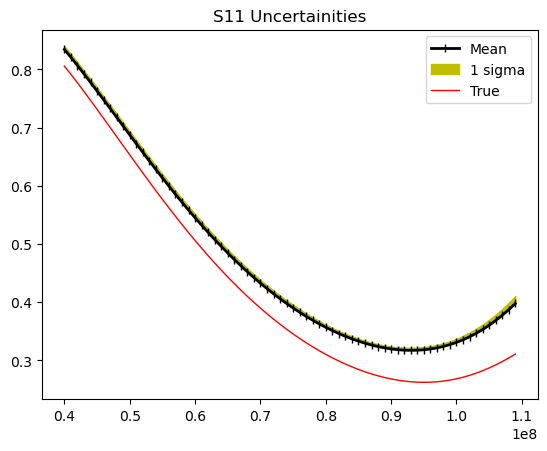

In [311]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
#plt.plot(v, S11_models_sky_ini[0::10].T, alpha=0.1)

S11_mean_sky_ini = np.mean(S11_models_sky_ini, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_sky_ini,[16,84],axis=0)

plt.plot(v, S11_mean_sky_ini, lw=2, color='k', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='y', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320

gA_True=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.legend()
plt.title("S11 Uncertainities")
plt.show()

Text(0.5, 1.0, 'Uncertainity in TA estimation')

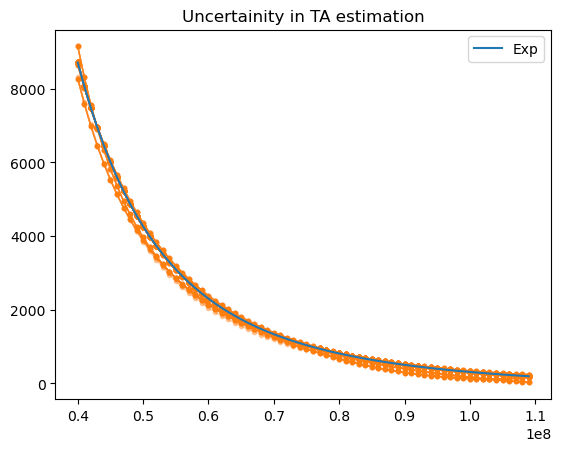

In [312]:
plt.figure()
#Reconstructing TA 
for ii in range(len(reduced_samples_sky_ini[::100])):
    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_sky_ini[ii]

    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    
    plt.plot(v, TA_obs, color='C1', marker='.',alpha=0.1, lw=1)

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
plt.plot(v,TA_exp, label="Exp")
plt.legend()
plt.title('Uncertainity in TA estimation')

125


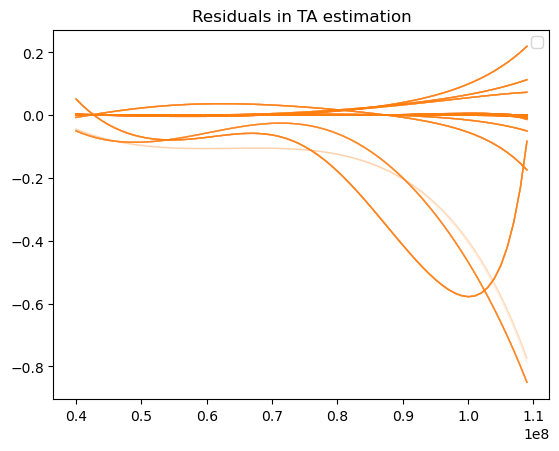

In [337]:
#Residuals in measuring TA 
plt.figure()
count=0
total=0
TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
for ii in range(len(reduced_samples_sky_ini[::100])):
    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_sky_ini[ii]
    total=total+1
    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    res=(np.array(TA_obs)-np.array(TA_exp))/np.array(TA_exp)
    if (np.amax(res)>0.1 or np.amin(res)<-0.1):
        count=count+1
    plt.plot(v, res, color='C1',alpha=0.1, lw=1)
    

plt.legend()
plt.title('Residuals in TA estimation')
print(count)

2.4849774027238025
0.030015114064048585


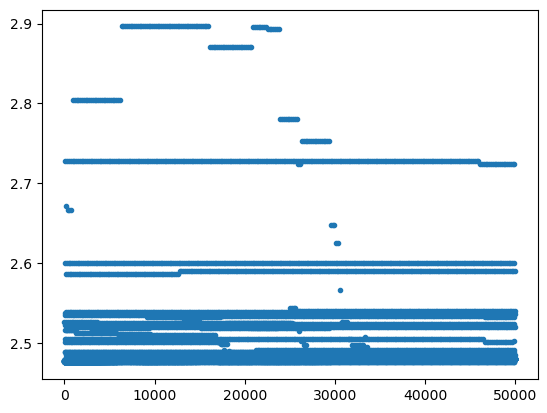

In [316]:
#checking other params
y=np.zeros(len(reduced_samples_joint[::10]))
for ii in range(len(reduced_samples_sky_ini[::10])):
    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_sky_ini[ii]
    y[ii]=a
    
x=np.arange(len(reduced_samples_joint[::10]))
print(np.mean(y))
print(st.stdev(y))
plt.plot(x,y,'.')

## S11 Fixed 

In [321]:
########## Define the log-likelihood function
def log_likelihood(params,**kwargs):

    ip_params = kwargs["ip_params"]
    s = kwargs["s"]
    seed=kwargs["seed"]
    v=kwargs["v"]

    # Compute TA expected
    
    a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN,gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    a,PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):
    
   
    a,PN, gamma_N, f, l = params
    #gamma_A=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
    if ((0<=gamma_N<=1) and a>0 and PN>0 and f>0 and l>0):#(250<PA<350) and (50<PN<150) and (0.05<f<0.5) and l>0):
        return 0.0  # Uniform prior
    return -np.inf #reject
    
######### Define the full log-probability function
    
def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_S11_fix(**kwargs):
    
    ## Number of walkers and steps
    
    ndim = 5  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=kwargs["initial_value"]

    ## Starting positions for the walkers
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler_s11_fix = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    mean_acc_frac=np.mean(sampler_s11_fix.acceptance_fraction)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler_s11_fix.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples_s11_fix=sampler_s11_fix.get_chain()
    samples_s11_fix = sampler_s11_fix.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes_s11_fix = np.array([log_likelihood(p,**kwargs) for p in samples_s11_fix])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes_s11_fix)
    
    ## Get the best-fit parameters
    
    best_fit_params_s11_fix = samples_s11_fix[max_likelihood_index].tolist()

    return full_samples_s11_fix,samples_s11_fix,best_fit_params_s11_fix #, mean_acc_frac #Mean Acceptance Ratio

In [322]:
s=0.001
seed=189
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
ip_params=[2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15]
PAo,gamma_Ao, PN, gamma_N, f, l=best_fit_params_o
a=2.3
#a, p0, p1, p2, p3, p4, p5, p6, p7=[2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           #1.01251329,  1.92753387,  5.23496320]
initials=[a, PN, gamma_N, f, l]


kwargs={"nsteps": nsteps, "ip_params": ip_params, "initial_value": initials, "s":s, "v":v, "seed":seed} #"PN":PN,  "gamma_N":gamma_N, "f":f, "l":l,


full_samples_s11_fix,samples_s11_fix,best_fit_params_s11_fix = evolve_MCMC_S11_fix(**kwargs)

Running MCMC...


100%|█████████████████████████████████████| 3000/3000 [1:07:04<00:00,  1.34s/it]


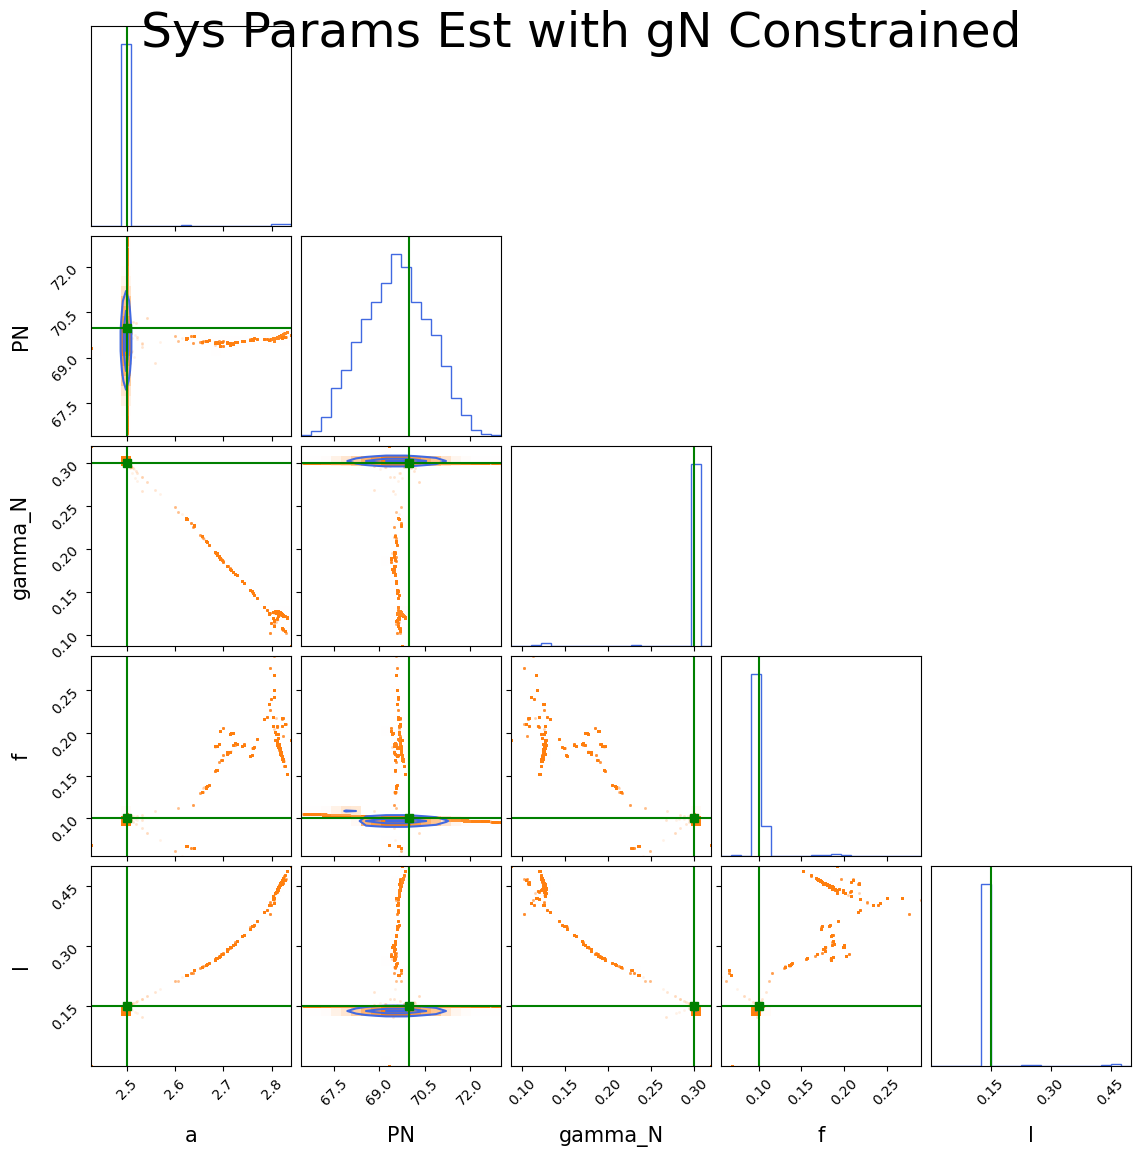

True values: [2.5, 70, 0.3, 0.1, 0.15]
Best-fit parameters (Maximum Likelihood Estimate): [2.500002600347135, 70.78180002567088, 0.2999973167584876, 0.09874047801604757, 0.1499927906116144]


In [329]:
parameter_names = ["a","PN","gamma_N","f","l"]
#corner plot 
sys_ip_params=[2.5,70,0.3,0.1,0.15]
fig = corner.corner(samples_s11_fix, labels=parameter_names, truths=sys_ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Sys Params Est with gN Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/RLC_1m_gA_gN_PA_l_1.png', dpi=300)
plt.show()

print("True values:", sys_ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_s11_fix)

Text(0.5, 1.0, 'S11 exp vs obs')

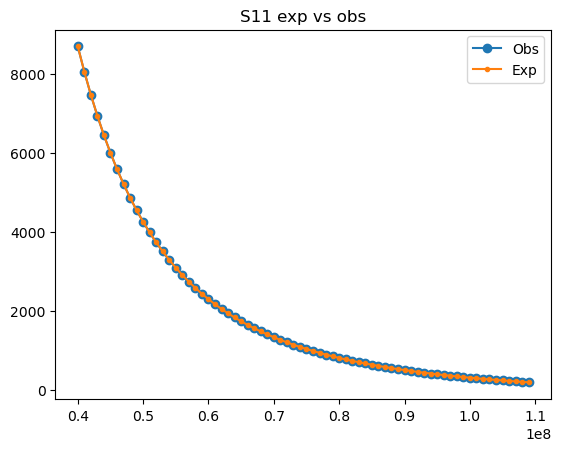

In [330]:
#Tmeas obs vs exp
a, PN, gamma_N, f, l= best_fit_params_s11_fix
p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320
TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)


TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)

plt.plot(v, TA_obs, marker='o', label="Obs")
plt.plot(v, TA_exp, marker='.', label="Exp")
plt.legend()
plt.title("S11 exp vs obs")

Text(0.5, 1.0, 'Uncertainity in TA estimation')

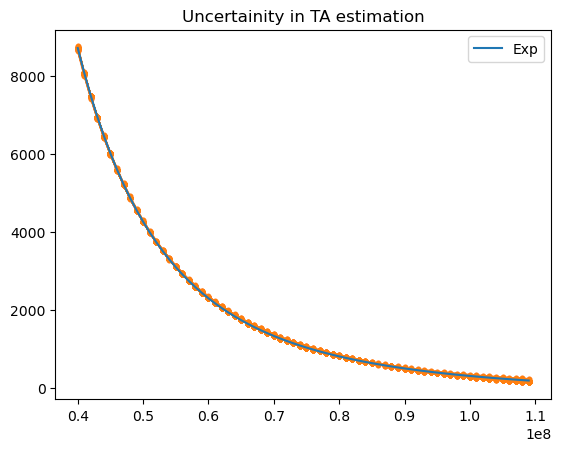

In [331]:
plt.figure()
#Reconstructing TA 
for ii in range(len(samples_s11_fix[::100])):
    a, PN, gamma_N, f, l= samples_s11_fix[ii]

    TA_obs=Compute_Tmeas_Sky(a, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, PN, gamma_N, f, l)
    
    plt.plot(v, TA_obs, color='C1', marker='.',alpha=0.1, lw=1)

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
plt.plot(v,TA_exp, label="Exp")
plt.legend()
plt.title('Uncertainity in TA estimation')

5000 200
70


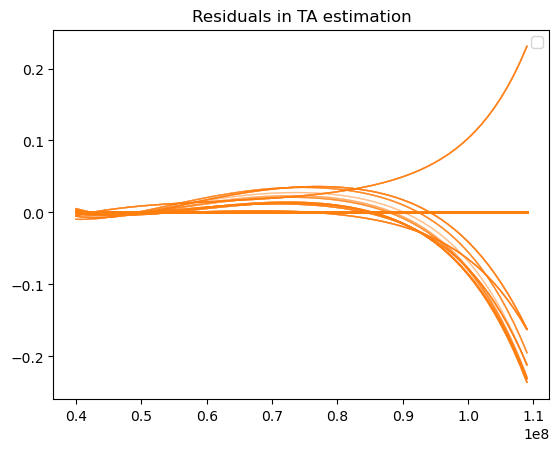

In [336]:
#Residuals in measuring TA 
plt.figure()
count=0
total=0
TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
for ii in range(len(samples_s11_fix[::100])):

    a, PN, gamma_N, f, l= samples_s11_fix[ii]
    p0, p1, p2, p3, p4, p5, p6, p7=  -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320
    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    res=(np.array(TA_obs)-np.array(TA_exp))/np.array(TA_exp)
    total=total+1
    if (np.amax(res)>0.1 or np.amin(res)<-0.1):
        count=count+1
    plt.plot(v, res, color='C1',alpha=0.1, lw=1)

plt.legend()
plt.title('Residuals in TA estimation')
print(total,count)
print(len(res))

## Joint Sky + Open

In [339]:
########## Define the log-likelihood function
def log_likelihood(params, **kwargs):
    
    ip_params=kwargs["ip_params"]
    seed=kwargs["seed"]
    v=kwargs["v"]
    
    PAo, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l = ip_params
    
    
    np.random.seed(seed)
    
    # Define the Expected TA values for open
    TA_exp_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp_o=np.array(TA_exp_o)

    # Define the Expected TA values for RLC
    TA_exp_sky = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp_sky=np.array(TA_exp_sky)

    PAo, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l = params
    
    # Compute model TA for open
    TA_model_o = Compute_Tmeas_(PAo, gamma_Ao, PN, gamma_N, f, l)
    TA_model_o=np.array(TA_model_o)

    # Compute model TA for open
    TA_model_sky = Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    TA_model_sky=np.array(TA_model_sky)
    
    # Compute chi-squared for open
    s = kwargs["s"] # Uncertainty
    chi2_o = np.sum([((TA_exp_o - TA_model_o)/s)** 2 ]) 

    # Compute chi-squared for RLC
    s = kwargs["s"]  # Uncertainty
    chi2_sky = np.sum([((TA_exp_sky - TA_model_sky)/s)** 2 ]) 

    # Likelihood function
    Likelihood= -0.5*chi2_o-0.5*chi2_sky#-2*np.log(math.sqrt(2*np.pi)*s) 
    return Likelihood

########## Define the log-prior function
def log_prior(params,**kwargs):
    
    PAo, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l = params
    v=kwargs["v"]
    gamma_A=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and (0<=gamma_Ao<=1) and (0<=gamma_N<=1) and (0.05<l<5) and PAo>0 and PN>0 and f>0):
        return 0.0  # Uniform prior
    return -np.inf #reject
          

######### Define the full log-probability function

def log_probability(params,**kwargs):
    lp = log_prior(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,**kwargs)

########### MCMC

def evolve_MCMC_Joint(**kwargs):# Define parameter names
 
    # Number of walkers and steps
    ndim = 15  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    ## Starting positions for the walkers
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    
    pos = np.array(pos_valid)
            
    #pos= initial_value[None,:] + initial_value*1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability(params):
        return log_probability(params, **kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p,**kwargs) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [340]:
s=0.001
nsteps=3000
v=[d[i][0] for i in range(len(d)-1)]
PA_o,gamma_Ao,PN,gamma_N,f,l=best_fit_params_o
a, PN, gamma_N, f, l= best_fit_params_s11_fix
p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320
seed=444

ip_params=[0, 1, 2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15]
initials=[PA_o, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l ]

kwargs={"nsteps":nsteps, "ip_params":ip_params,"initial_value": initials, "s":s, "v":v, "seed":seed}

full_samples_joint, samples_joint, best_fit_params_joint= evolve_MCMC_Joint(**kwargs)

Running MCMC...


100%|█████████████████████████████████████| 3000/3000 [1:37:33<00:00,  1.95s/it]


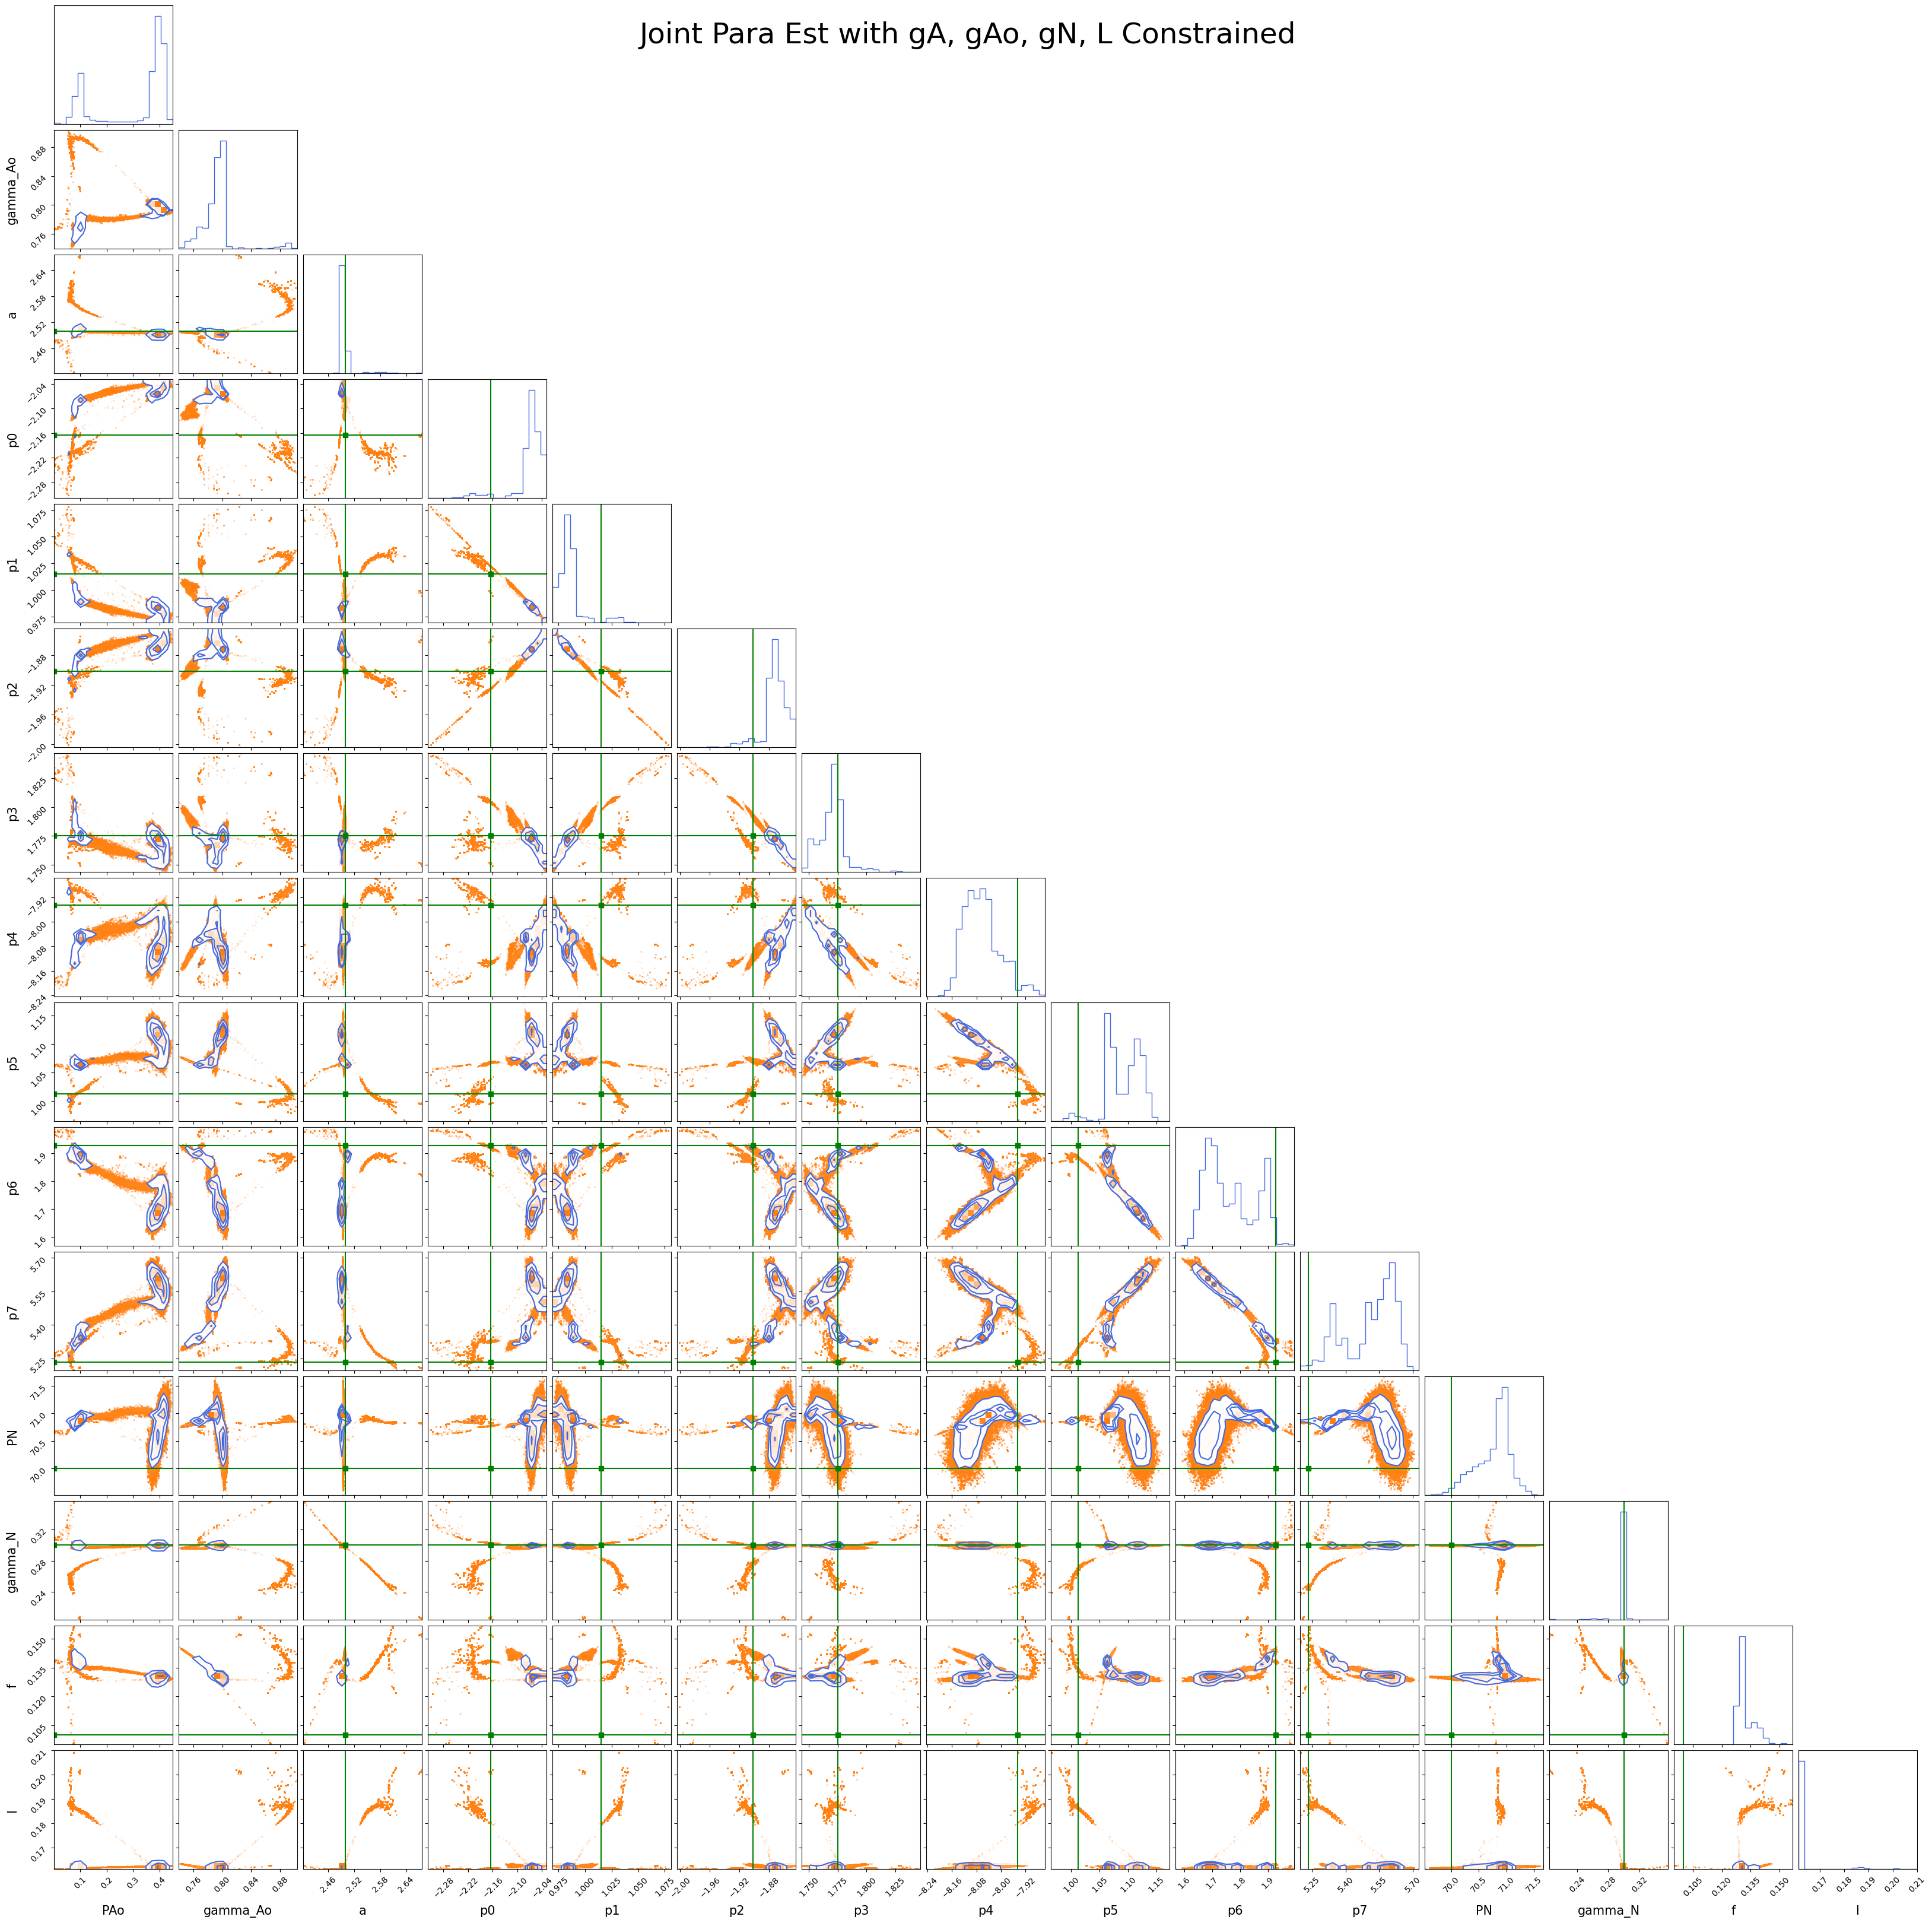

Best-fit parameters (Maximum Likelihood Estimate): [0.3604201944180066, 0.8044494314973821, 2.4929686752587576, -2.065070475075056, 0.9843610390940409, -1.8709578855912403, 1.7720181120220126, -8.107067058473747, 1.1266082399014414, 1.6515030284048213, 5.647526873894815, 70.33305466837623, 0.30046360852690235, 0.12867198319081988, 0.16136356960415205]


In [341]:
parameter_names = ["PAo", "gamma_Ao", "a", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_joint, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Joint Para Est with gA, gAo, gN, L Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Joint_ORLC_1_gA_gAo_gN_L_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_joint)

Text(0.5, 1.0, 'S11 exp vs obs')

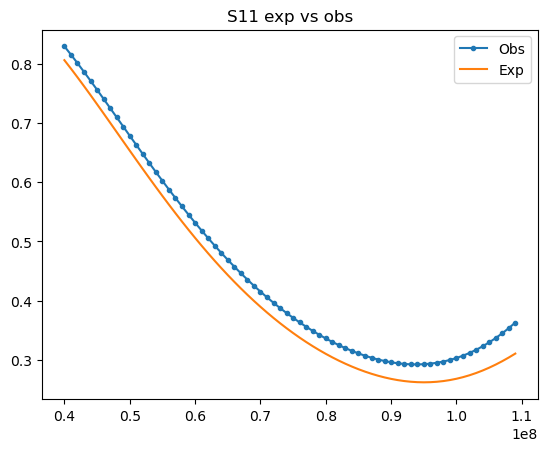

In [342]:
PA_o, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= best_fit_params_joint
TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
S11_obs=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320
S11_actual=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
plt.plot(v, S11_obs, marker=".", label="Obs")
plt.plot(v, S11_actual, label="Exp")
plt.legend()
plt.title("S11 exp vs obs")

Text(0.5, 1.0, 'Tmeas Expected vs Observed')

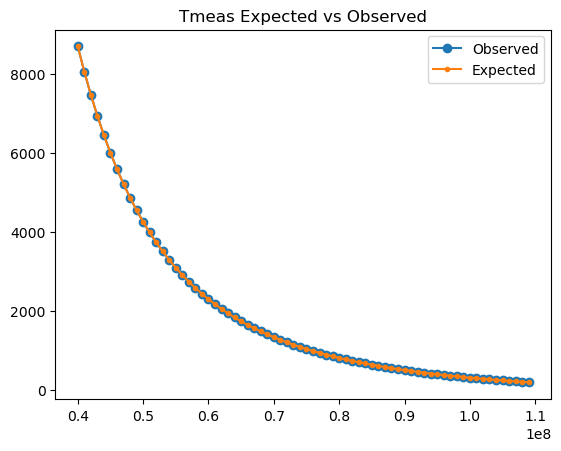

In [343]:
plt.plot(v,TA_obs,marker='o', label="Observed")
plt.plot(v,TA_exp, marker='.', label="Expected")
plt.legend()
plt.title("Tmeas Expected vs Observed")

In [344]:
#computing S11 corresponding to all samples
reduced_samples_joint = samples_joint
S11_models_joint = np.zeros((len(reduced_samples_joint), len(v)))

for ii in range(len(reduced_samples_joint)):
    PA_o, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_joint[ii]
    S11_models_joint[ii]=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)

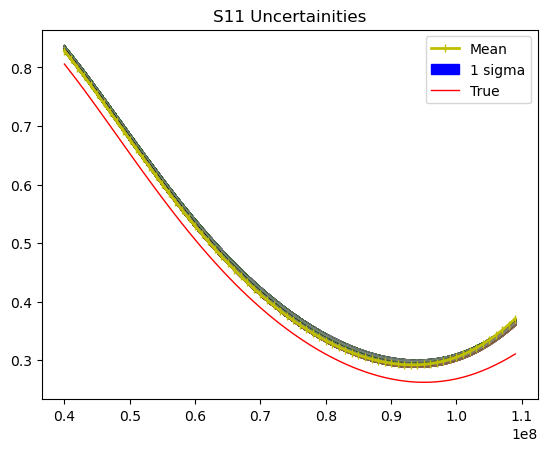

In [345]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
plt.plot(v, S11_models_joint[0::100].T, alpha=0.1)

S11_mean_joint = np.mean(S11_models_joint, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_joint,[16,84],axis=0)

plt.plot(v, S11_mean_joint, lw=2, color='y', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6, p7= -2.16471339,  1.01479542, -1.90174747, 1.77491206, -7.94569882,\
           1.01251329,  1.92753387,  5.23496320

gA_True=np.polyval([p0*1e-55, p1*1e-46, p2*1e-38, p3*1e-30, p4*1e-23, p5*1e-15, p6*1e-08, p7*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.legend()
plt.title("S11 Uncertainities")
plt.show()

Text(0.5, 1.0, 'Uncertainity in TA estimation')

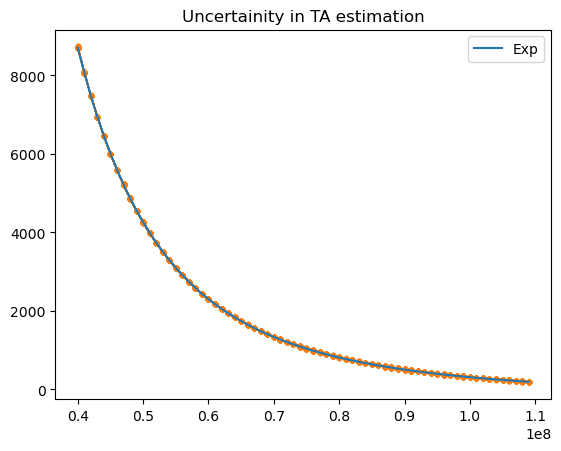

In [346]:
plt.figure()
#Uncertainities in Tmeas
for ii in range(len(reduced_samples_joint[::100])):
    PA_o, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_joint[ii]

    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    
    plt.plot(v, TA_obs, color='C1', marker='.',alpha=0.1, lw=1)

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
plt.plot(v,TA_exp, label="Exp")
plt.legend()
plt.title('Uncertainity in TA estimation')

Text(0.5, 1.0, 'Residuals in Tmeas estimation')

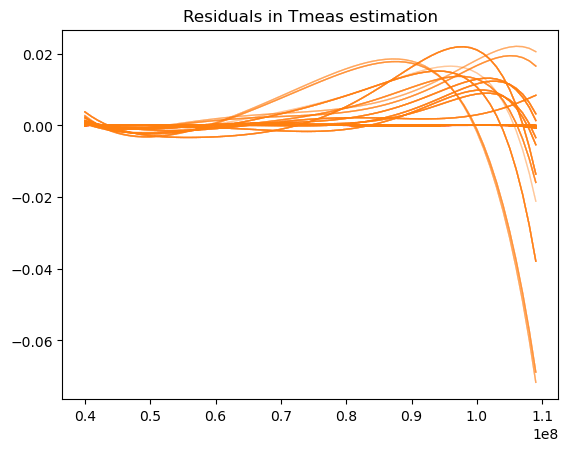

In [347]:
plt.figure()
#Residuals in Tmeas

TA_exp=Compute_Tmeas_Sky(2.5, -2.16471339,  1.01479542, -1.90174747,\
                                                       1.77491206, -7.94569882, \
                                                       1.01251329,  1.92753387,  5.23496320, 70, 0.3, 0.1, 0.15)
for ii in range(len(reduced_samples_joint[::100])):
    PA_o, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_joint[ii]

    TA_obs=Compute_Tmeas_Sky(a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l)
    res=(np.array(TA_obs)-np.array(TA_exp))/np.array(TA_exp)
    plt.plot(v, res, color='C1',alpha=0.1, lw=1)


plt.title('Residuals in Tmeas estimation')

0.15760895150185375
0.0050934949773523315


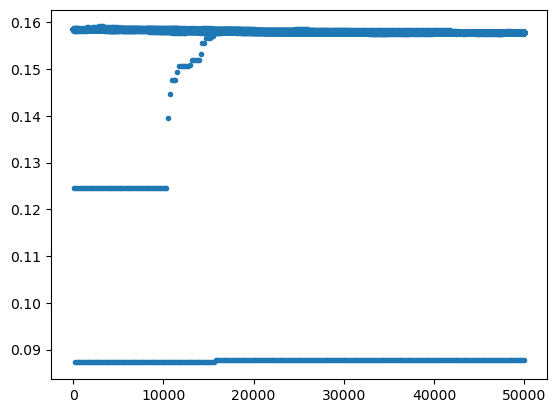

In [245]:
#checking other params
y=np.zeros(len(reduced_samples_joint[::10]))
for ii in range(len(reduced_samples_joint[::10])):
    PA_o, gamma_Ao, a, p0, p1, p2, p3, p4, p5, p6, p7, PN, gamma_N, f, l= reduced_samples_joint[ii]
    y[ii]=l
x=np.arange(len(reduced_samples_joint[::10]))
print(np.mean(y))
print(st.stdev(y))
plt.plot(x,y,'.')